# Inference and validation of the Jansen & Rit Neural Mass Model posterior

1. Posterior estimation via `sbi`-library 
2. Global validation metrics include 
    - SBC (`sbi` implementation), 
    - HPD (`lampe` implementation adapted to `sbi` posterior objects)
    - multi-PIT (ours)
    - C2ST (`sbi` implementation): only cross-val score (no hypothesis test)
    - Global L-C2ST (ours)
3. Local validation metrics include
    - Local multi-PIT (ours: marginal uniformity with method from Zhao et al.)
    - L(ocal)-C2ST (ours): cross-val score and hypothesis tests

In [32]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


import os
from pathlib import Path
from functools import partial

## SBI Task: Inference of the JR-NMM parameters under uniform prior


- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where } \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

    For simplicity, we use the notation $x$ when we actually refer to $s(x)$.

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid x_0)$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$.

### Experimental SETUP

#### Global Variables

In [7]:

# PATH
PATH_EXPERIMENT = '../saved_experiments/JR-NMM/normal_4d/'

# DATASETS
B = 50_000 # train flow
B_PRIME = 10_000 # cal set / trianing classifiers for validation diagnostics
B_DOUBLE_PRIME = 1_000 # evaluate 
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
# ground-truth gain parameter
GT_GAIN = 0

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
METHOD = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

#### Meta-parameters

In [8]:
from hnpe.misc import make_label

meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [9]:
from tasks.jrnmm.simulator import prior_JRNMM, simulator_JRNMM
from tasks.jrnmm.summary import summary_JRNMM

# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=meta_parameters['t_recording'],
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [10]:
from tasks.jrnmm.posterior import build_flow, IdentityJRNMM, get_posterior

# posterior used for Neurips WS paper (old version of sbi...)
filename = PATH_EXPERIMENT+f'posteriors_amortized/{METHOD}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True,
                                n_layers=5)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0, path=PATH_EXPERIMENT+'Flows_amortized/JRNMM_nextra_00_trec_8naive_True_single_rec_False_n_layers_5/Fourier_n_rd_1_n_sr_50000_n_sf_33/'
    )
    torch.save(posterior, filename)

# Validation

### Dataset generation

In [11]:
from sbi.inference import simulate_for_sbi

# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{METHOD}.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

x_cal, theta_cal = datasets['B_prime']['x'], datasets['B_prime']['theta'] # 10_000
x_cal.shape, theta_cal.shape


(torch.Size([10000, 33, 1]), torch.Size([10000, 4]))

#### Recover order via Permutations

In [12]:

theta_new = datasets['B_prime']['theta'][:1]
print(theta_new)
for i in range(10):
    theta_new = posterior._flow._transform._transforms[1]._transforms[i]._transforms[1](theta_new)[0]
print(theta_new)

def apply_permutations(list):
    list_new = []
    permuted_ids = [2,3,1,0]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

def apply_inv_permutations(list):
    list_new = []
    permuted_ids = [3,2,0,1]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

tensor([[ 104.0939,   98.6300, 3300.2747,  -18.1834]])
tensor([[3300.2747,  -18.1834,   98.6300,  104.0939]])


In [13]:
param_names = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
colors=['orange', 'red', 'purple', 'blue']

param_names_permuted = apply_permutations(param_names)
colors_permuted = apply_permutations(colors)

## Global COVERAGE for multivariate density NPEs
We show the global PIT-distribution for the JR-NMM NPE for which correlations play an important role. We can see that there is a problem in two dimensions (the estimator is biased). We will apply the 1D local coverage test [Zhao et al.] on each dimension to get more insight on the behavior of the estimator.

### 1. PP-plots (marginal uniformity): Global PIT vs. SBC vs. HPD

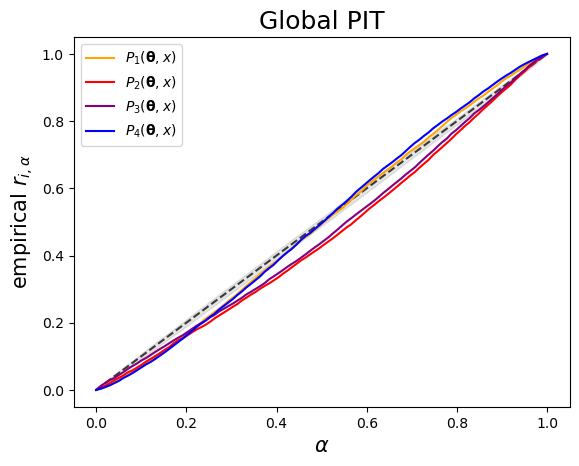

In [14]:
from valdiags.pp_plots import multi_cde_pit_values, PP_plot_1D, sbc_plot, confidence_region_null, multi_pp_plots

# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_cal, x_cal, posterior,
)
flow_joint_pit_values = [flow_joint_pit_values[i] for i in range(4)]

# flow_joint_pit_values_permuted = apply_inv_permutations(flow_joint_pit_values)

# PP-plot of expected PIT-distribution 
# r_alpha = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors=colors,
    labels=[r'$P_1(\mathbf{\theta},x)$', r'$P_2(\mathbf{\theta},x)$', r'$P_3(\mathbf{\theta},x)$', r'$P_4(\mathbf{\theta},x)$'],
    title="Global PIT",
    ylabel=r"empirical $r_{i,\alpha}$",
    confidence_int = True,
    conf_alpha=0.05/4, # bonferonni correction: global level at 0.05
)

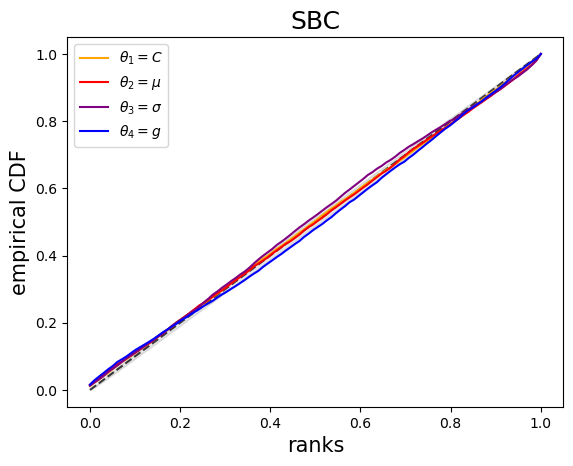

In [15]:
from sbi.analysis.sbc import run_sbc
from sbi.inference.posteriors.direct_posterior import DirectPosterior
# posterior_sbc = DirectPosterior(posterior_estimator=posterior, prior=prior,
#         x_shape=datasets['B_prime']['x'][0][None, :].shape)

# sbc = run_sbc(datasets['B_prime']['theta'], datasets['B_prime']['x'][:,None,:,:], posterior=posterior_sbc)
# torch.save(sbc, PATH_EXPERIMENT+'sbc_prime.pkl')

sbc_ranks = np.array(torch.load(PATH_EXPERIMENT+'global_tests/sbc_prime.pkl')[0])
colors=colors
labels = param_names
sbc_plot(sbc_ranks, colors=colors, labels=labels, conf_alpha=0.05/4) # bonferonni correction: global level at 0.05*4 = 0.2

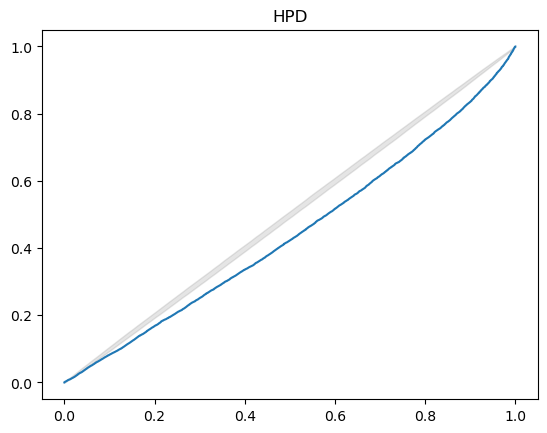

In [16]:
from valdiags.hpd_coverage import highest_density

if os.path.exists(PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl'):
    hpd_values = torch.load(PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl')
else:
    hpd_values, alphas = highest_density(posterior, theta_cal, x_cal)
    torch.save(hpd_values, PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl')

alphas_hpd = np.linspace(0.0, 1.0, len(hpd_values))
alphas = np.linspace(0, 1, 100)
confidence_region_null(alphas, N=B_PRIME, conf_alpha=0.05) # bonferonni correction
plt.plot(alphas_hpd, hpd_values)
plt.title("HPD")
plt.show()

### 2. Vanilla C2ST and Global L-C2ST

In [18]:
import torch.distributions as D

inv_flow_samples = posterior._transform(theta_cal, context=x_cal)[0].detach()
norm_samples = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),))
norm_samples_2 = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),)) # for null hyp

In [19]:
# Vanilla C2ST: # z_n ~ N(0,1) vs. T(\theta_n, x_n)
from sbi.utils.metrics import c2st_scores

scores = c2st_scores(norm_samples, inv_flow_samples, n_folds=10)
print('flow:', np.mean(scores).__round__(2), '+/-', np.std(scores).__round__(2))

flow: 0.54 +/- 0.01


In [21]:
# Global test for l-c2st : [z_n, x_n] vs. [T(\theta_n, x_n), x_n]
from valdiags.localC2ST import expected_lc2st_scores

df_explc2st_jrnmm = pd.DataFrame(
    expected_lc2st_scores(norm_samples, inv_flow_samples, x_cal[:,:,0])
)

df_explc2st_null = pd.DataFrame(
    expected_lc2st_scores(norm_samples, norm_samples_2, x_cal[:,:,0])
)

df_explc2st = pd.DataFrame({})

dfs = [pd.concat(
    [
        df.mean(axis=0).rename("mean"),
        df.std(axis=0).rename("std"),
    ], axis=1) for df in [df_explc2st_jrnmm,  df_explc2st_null]]
df_explc2st = pd.concat(dfs, keys=["jrnmm_npe", "null"])
df_explc2st.round(2)

mean   std
jrnmm_npe accuracy     0.63  0.01
          probas_mean  0.57  0.02
null      accuracy     0.50  0.01
          probas_mean  0.50  0.02

### Neurips images

In [22]:
# colors_sbc = ['#95BF74', '#519F54', '#417448', '#31493C']
# colors_sbc = ['#FFCAD4', '#F4ACB7', '#AC5F7B', '#64113F']
colors_sbc = ['#B9D6AF', '#B2C695', '#81B598', '#519D7A']
# colors_pit = ['#3BCEAC','#FFD23F','#EE4266','#540D6E']
colors_pit = ['#C095EE','#FFD23F','#EE4266','#540D6E']

labels_sbc = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
labels_pit = [r'$P_{1}(\mathbf{\theta})$', r'$P_{2}(\mathbf{\theta})$', r'$P_{3}(\mathbf{\theta})$', r'$P_{4}(\mathbf{\theta})$']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


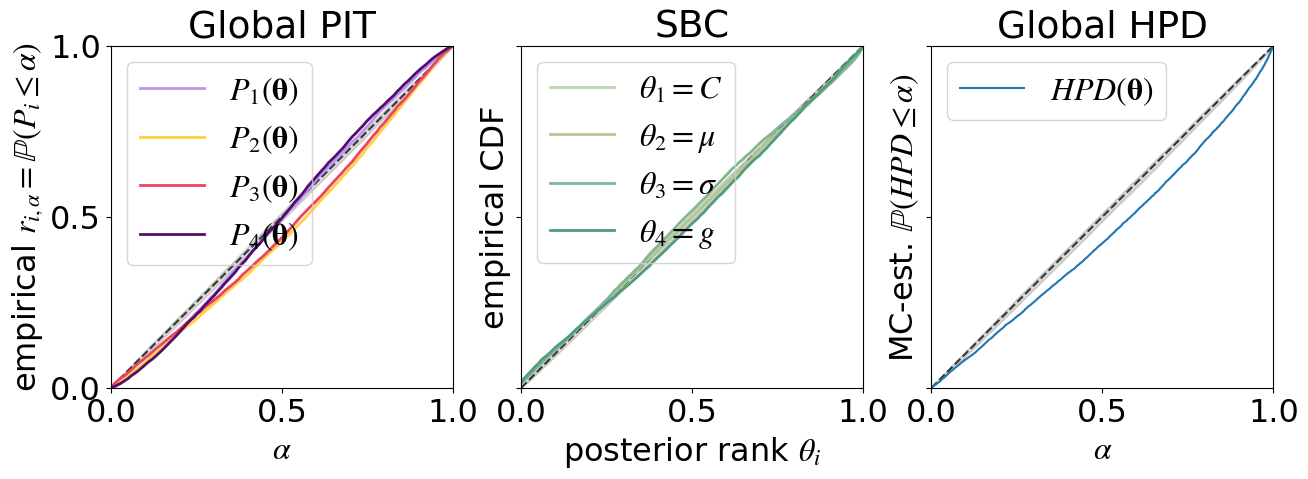

In [23]:
from plots_neurips2022 import multi_global_consistency

fig = multi_global_consistency(multi_PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors_sbc=colors_sbc,
    colors_pit=colors_pit,
    labels_sbc=labels_sbc,
    labels_pit = labels_pit,
    sbc_ranks=sbc_ranks,
    hpd_values=hpd_values
    )


# plt.savefig(PATH_EXPERIMENT+'images_neurips/global_consistency.pdf')

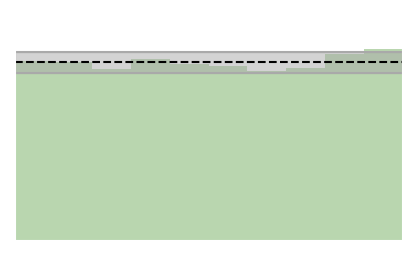

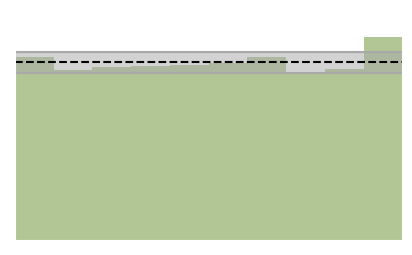

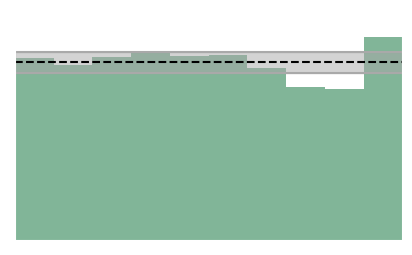

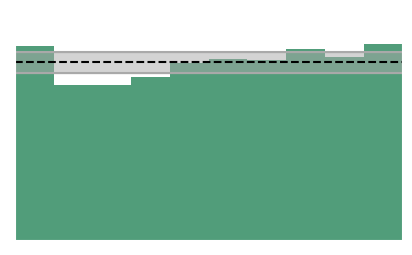

In [24]:
from plots_neurips2022 import global_histograms
for i in range(4):
    fig = global_histograms(sbc_ranks[:,i]/1000, color=colors_sbc[i], conf_alpha=0.05) # bonferonni correction: global level at 0.05*4 = 0.2
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_SBC_dim{i}.pdf')
    plt.show()

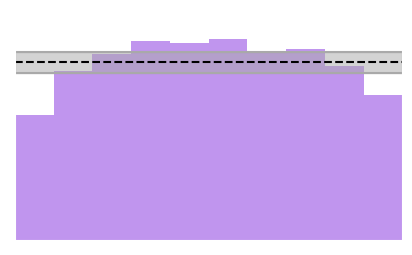

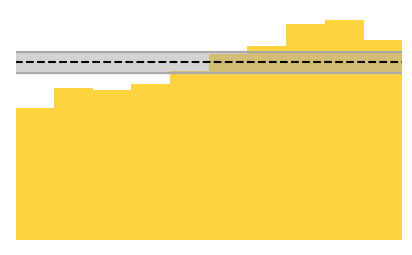

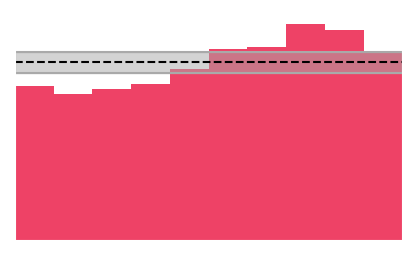

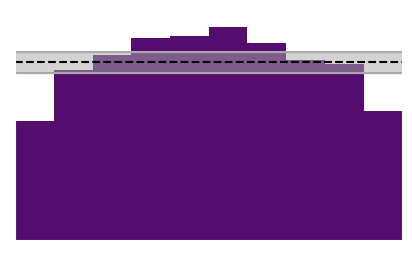

In [25]:
for i in range(4):
    fig = global_histograms(flow_joint_pit_values[i], color=colors_pit[i], conf_alpha=0.05) # bonferonni correction: global level at 0.05*4 = 0.2
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalPIT_dim{i}.pdf')
    plt.show()

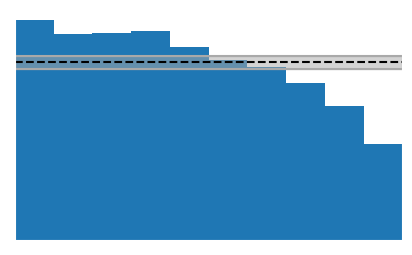

In [26]:
fig = global_histograms(np.array(hpd_values).ravel(), color='#1f77b4', conf_alpha=0.05*4) # bonferonni correction: global level at 0.05*4 = 0.2
plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalHPD.pdf')
plt.show()

## LOCAL COVERAGE:

### Ground-truth parameters and observations for evaluation

We know that the parameters $(\mu, \sigma)$ and $g$ are coupled.

We thus choose to analyse the behavior of the estimator on a 1D cut through the parameter space, i.e. at different $x_0 = \text{Simulator}(C_0, \mu_0, \sigma_0, g_0)$ where $C_0, \mu_0, \sigma_0$ are fixed and we only vary the gain parameter $g_0 \in [-20,20]$.

**Intuition:** The average gain value is $\sum_{g=-20}^{20} g = 0$. We expect a consistent estimator at $g_0 = 0$, as the estimator is trained to maximize the ***average*** log-likelihood. If this is true, we would expect inconsistent behavior at $g_0 \neq 0$, because the estimator is globally biased for $(\mu, \sigma)$.

In [27]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-25,25,11)

# theta_true_list = []

# x_obs_list = []
# for g in gain_list:
#     theta_true = torch.FloatTensor([c, mu, sigma, g])
#     meta_parameters['theta'] = theta_true
#     theta_true_list.append(theta_true)

#     ground_truth = get_ground_truth(meta_parameters,
#                                 input_parameters=['C', 'mu', 'sigma', 'gain'],
#                                 p_gain=prior, single_recording=SINGLE_REC)
#     ground_truth['observation'] = summary_extractor(ground_truth['observation'])
#     x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
#     x_obs_list.append(x_obs)
# # torch.save([theta_true, torch.stack(x_obs_list)[:,0,:,:]], PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')

x_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')[1]
x_obs_list.shape


torch.Size([11, 33, 1])

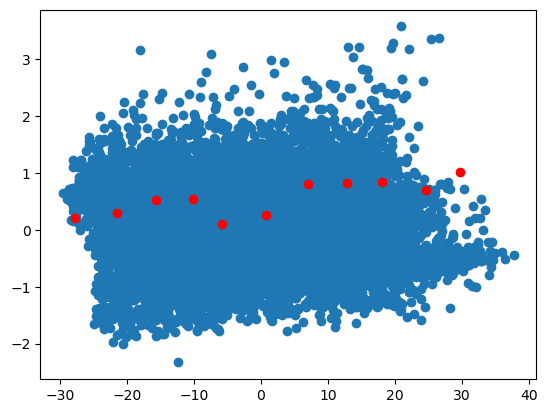

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cal[:,:,0]) 
x_new = pca.transform(x_cal[:,:,0])

mpl.rcParams.update(mpl.rcParamsDefault)
plt.scatter(x_new[:,0],x_new[:,1])
x_new_obs = pca.transform(x_obs_list[:,:,0])
plt.scatter(x_new_obs[:,0],x_new_obs[:,1], color='red')
plt.show()

### 1. Local PIT: marginal uniformity

In [30]:
from valdiags.multi_local_test import get_lct_results

path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t1000_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{100}_n_alphas_{100}"
)  # no pvalues, used to compute Test statistic and pp-pplot

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t1000_na100_path_list = []

for g in gain_list:
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")


df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

#### PP-plots

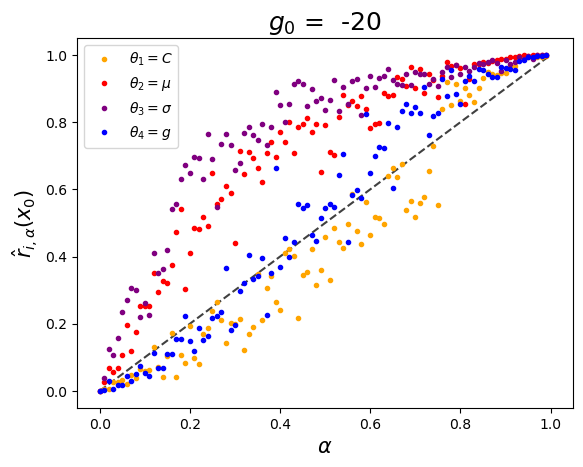

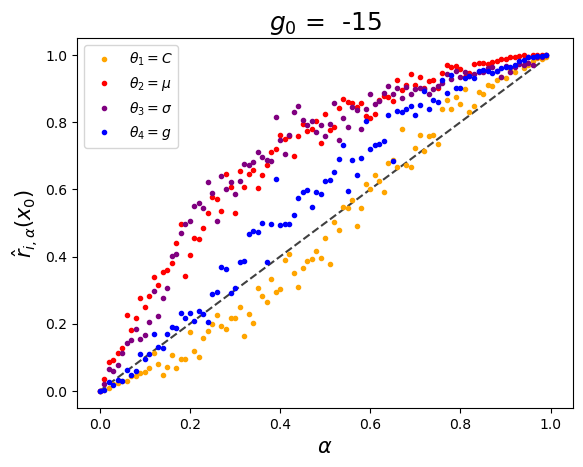

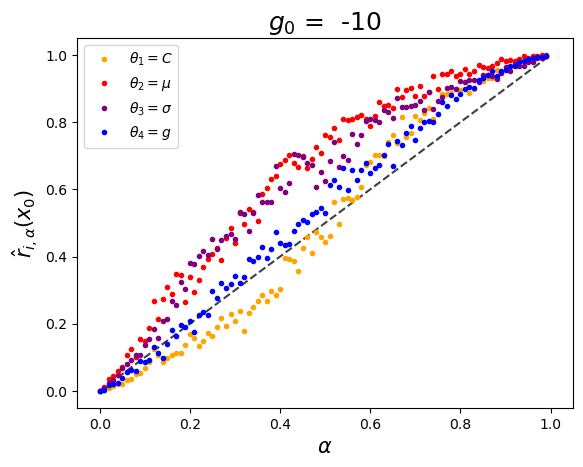

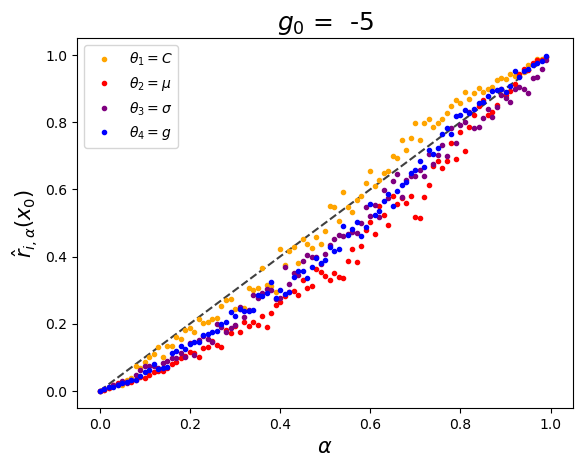

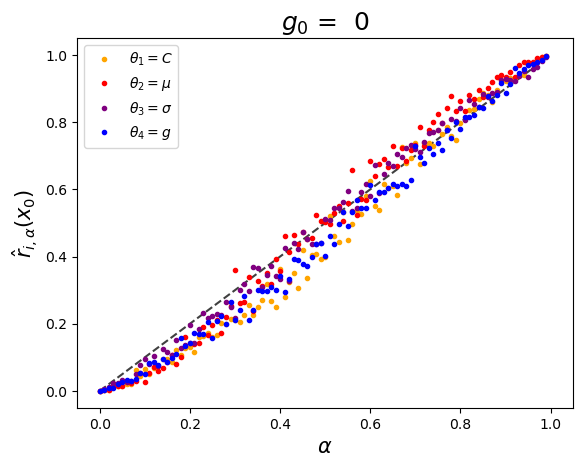

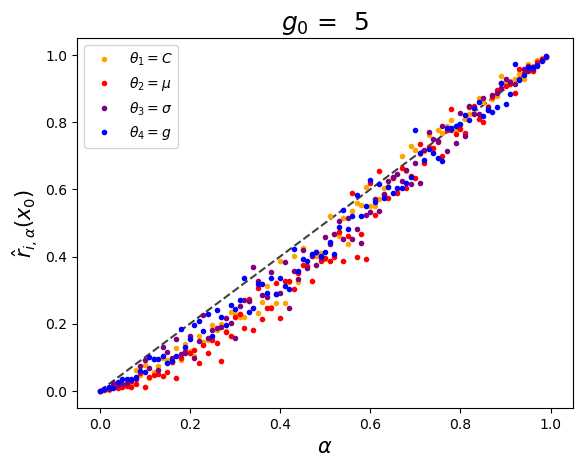

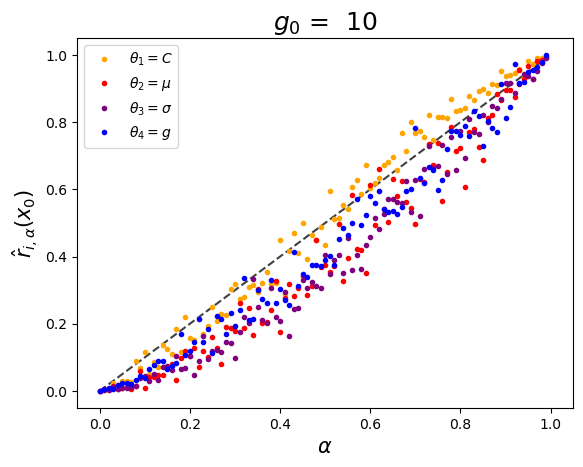

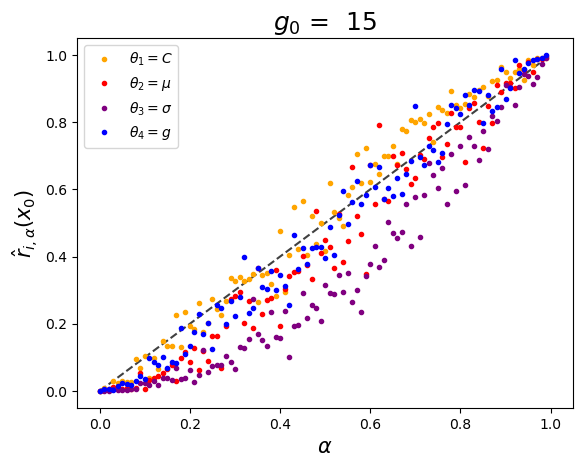

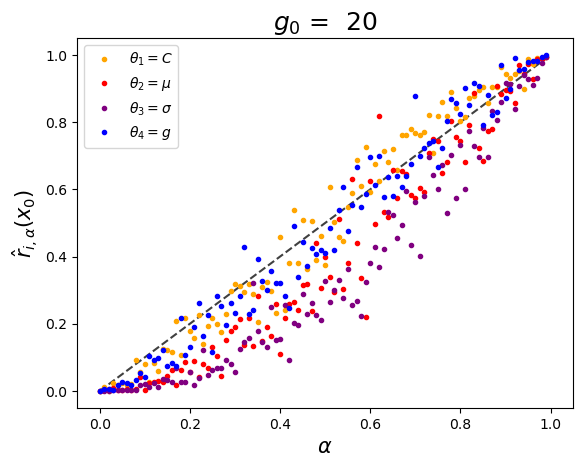

In [34]:
# pp-plots for accepted x_0
# from diagnostics.pp_plots import multi_pp_plots
mpl.rcParams.update(mpl.rcParamsDefault)
x_eval_names = [r"$g_0$ = " + f" {g}" for g in gain_list]
param_names = [r"$\theta_1=C$ ", r"$\theta_2=\mu$ ", r"$\theta_3=\sigma$ ", r"$\theta_4=g$ "]
multi_pp_plots(
    [
        # [
        #     lct_base_t1000_na100_path_list[0],
        #     lct_base_t1000_na100_path_list[4],
        #     lct_base_t1000_na100_path_list[8],
        # ]
        lct_base_t1000_na100_path_list
    ],
    x_eval_names,
    param_names,
    pvalues=False,
    title="",
    ylabel=r"$\hat{r}_{i,\alpha}(x_0)$"
)



#### Test Statistic 

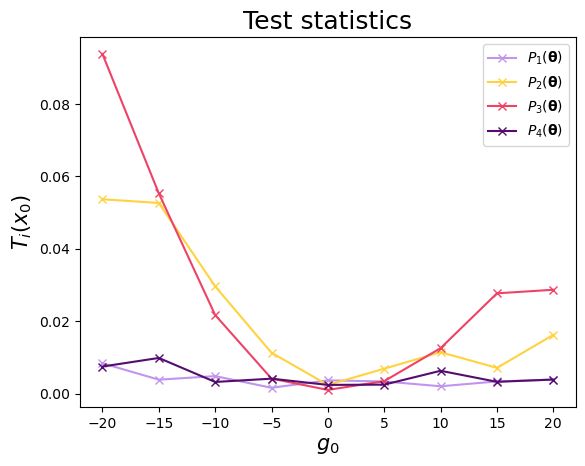

In [35]:
mpl.rcParams.update(mpl.rcParamsDefault)
# T_permuted = apply_inv_permutations([df_base_na100[f'dim_{i}'] for i in range(1,5)])
id = list(range(4))
iperm = apply_inv_permutations(id)
for i,ip in zip(id,iperm):
    plt.plot(gain_list, df_base_na100[f'dim_{i+1}'], marker='x', color=colors_pit[i],label=labels_pit[i])

plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{i}(x_0)$', fontsize=15)
plt.title(r'Test statistics', fontsize=18)
plt.legend()
plt.show()

#### Null hypothesis and p-values

In [36]:
n_trials=100
path_lct_base_t100_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{n_trials}_n_alphas_{100}"
) 

gain_list_new = [-20,0,20]

r_alpha_null_list = []
for g in gain_list_new:
    dict_null = torch.load(path_lct_base_t100_na100 + f"_gain_{g}.pkl")
    r_alpha_null = {}
    for k in range(n_trials):
        r_alpha_null[k] = pd.Series(dict_null['r_alpha_null_list'][k]['dim_1'])
    r_alpha_null_list.append(r_alpha_null)

In [37]:
df = get_lct_results(lct_base_t1000_na100_path_list)
df.loc[:, df.columns.str.contains('p_values')]

p_values__dim_1  p_values__dim_2  p_values__dim_3  p_values__dim_4  \
0             0.00              0.0             0.00             0.01   
1             0.00              0.0             0.00             0.00   
2             0.00              0.0             0.00             0.00   
3             0.03              0.0             0.00             0.00   
4             0.00              0.0             0.12             0.00   
5             0.00              0.0             0.00             0.00   
6             0.10              0.0             0.00             0.00   
7             0.00              0.0             0.00             0.02   
8             0.15              0.0             0.00             0.12   

   p_values__hmean  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0

### 2. Local C2ST 


#### Choice of classification model and cal-set size

##### Accuracy - Shift-experiment
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up. We still need to add results for `'lda'` and `'qda'`.

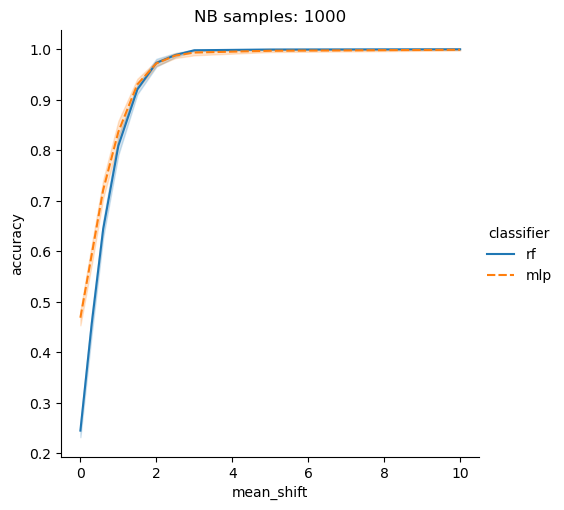

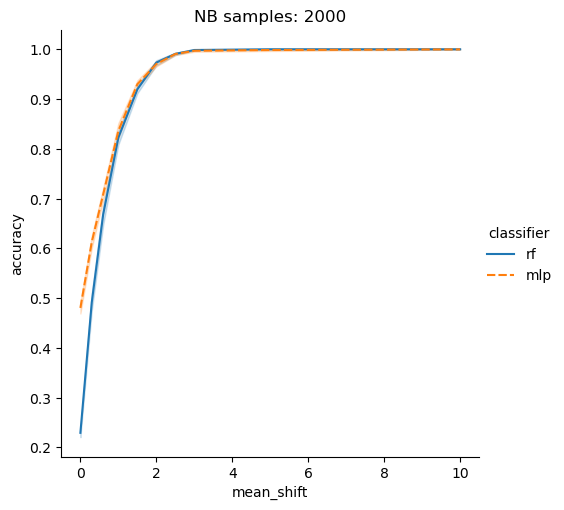

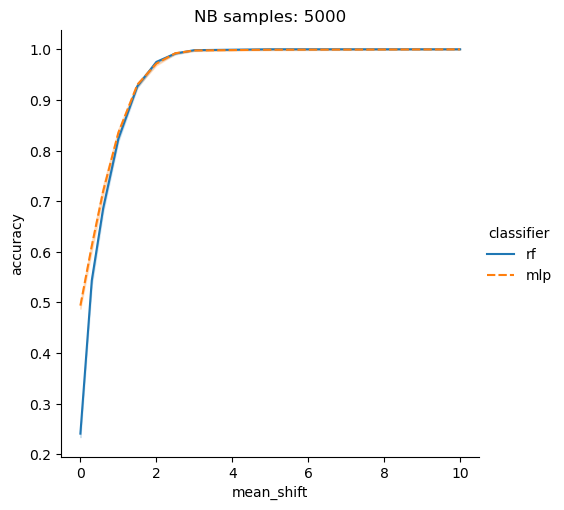

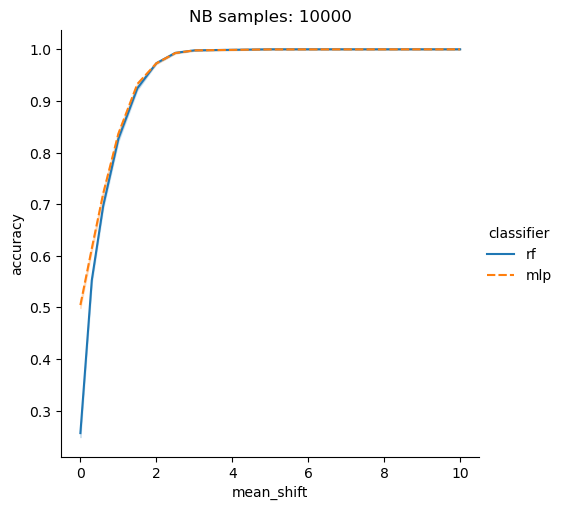

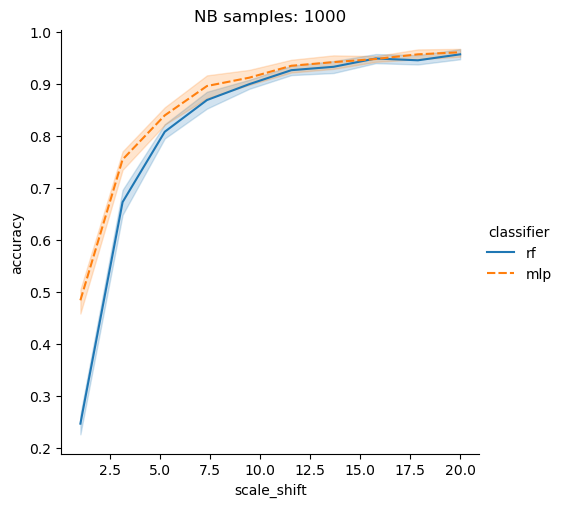

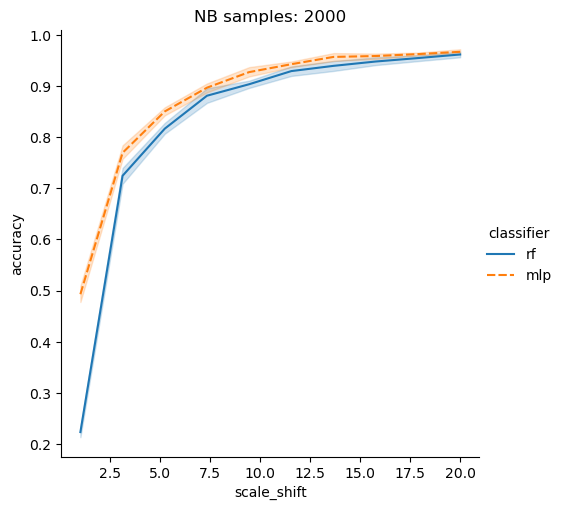

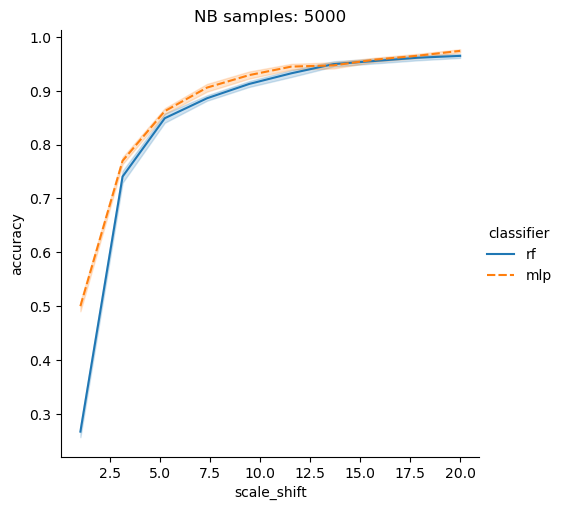

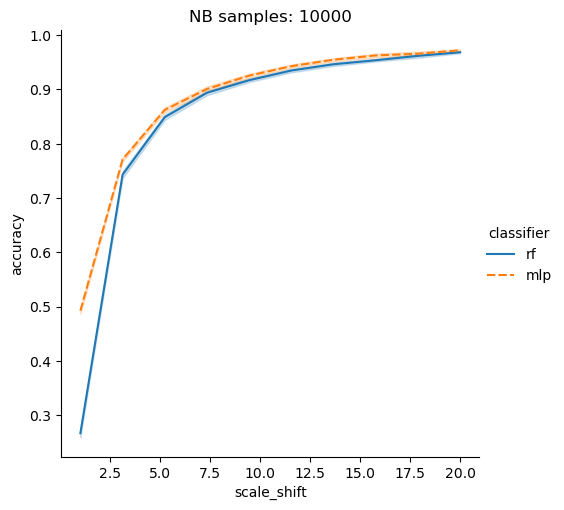

In [17]:
# n_trials = 10
N = [1000, 2000, 5000, 10000]
dfs_mean = {}
dfs_scale = {}
for n in N:
    dfs_mean[n] = torch.load(PATH_EXPERIMENT+f'lc2st_eval_clfs/df_mean_{n}.pkl')
    dfs_scale[n] = torch.load(PATH_EXPERIMENT+f'lc2st_eval_clfs/df_scale_{n}.pkl')

# mean shift
import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

# scale shift
for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Precision under the null hypothesis - cal-set size
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up.


test_stats



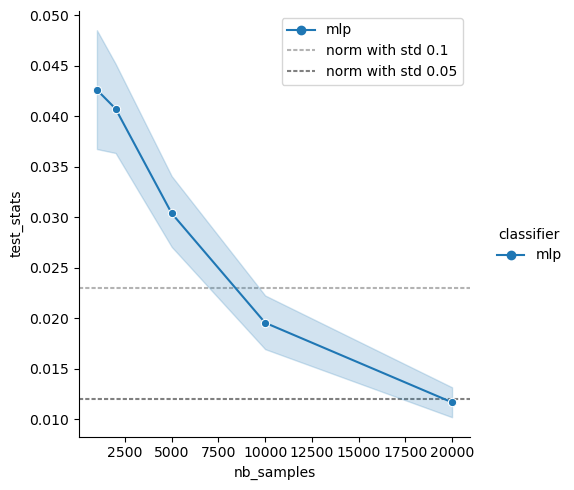


w_dist



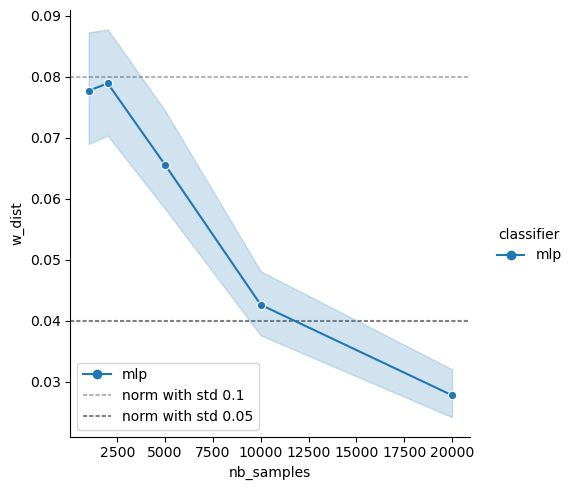

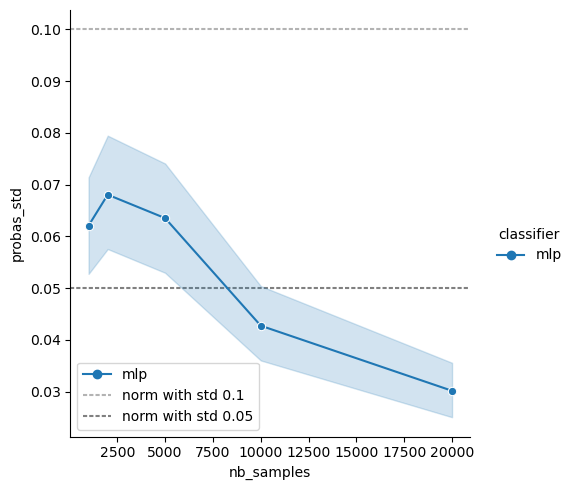


test_stats



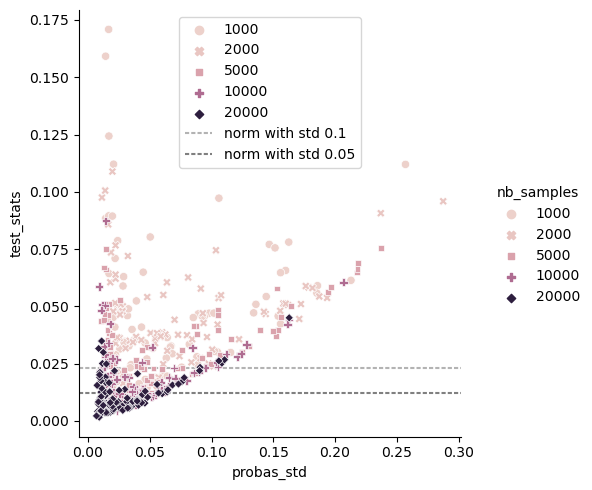


w_dist



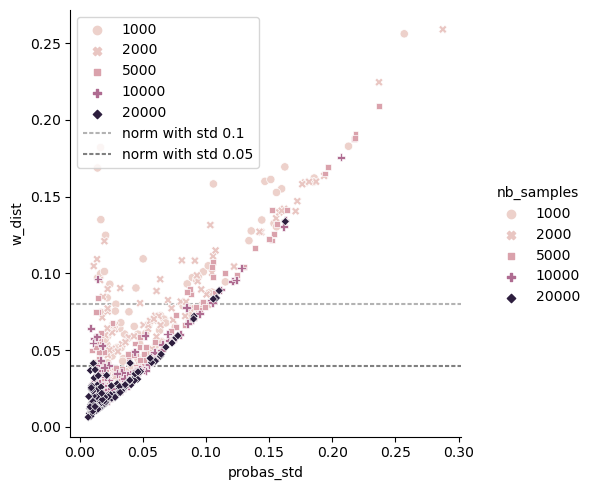

In [51]:
dfs = []
for n in [1000, 2000, 5000, 10000, 20000]:
    dfs.append(torch.load(PATH_EXPERIMENT+f'lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats_wdist.pkl'))

df = pd.concat(dfs, ignore_index=True)

for T, y1, y2 in zip(['TV_dist', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()

g = sns.relplot(
        data=df, x="nb_samples", y="probas_std",
        hue="classifier", style="classifier", kind="line", markers='o'
    )
g.map(plt.axhline, y=0.1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.05, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()

for T, y1, y2 in zip(['TV_dist', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max()

Results:
- plot 1 - TV_dist: the wanted test statistics are obtained for a sample size of 10_000 (for 0.1 std) and 20_000 (for 0.05 std)
- plot 2 - w_dist: the wanted test statistics are obtained for a sample size of ~12_500 (for 0.05 std) and always fpr 0.1 std
- plot 3/4: Larger sample sizes ensure small test statistics for small stds (closer to theory). For the TV_dist, there are still data points with predicted stds that are above the theory (points with test stat below the line but with std larger than 0.05/0.1), this is not really the case for w_dist. 

1. The wasserstein distance seems to lead to statistically more powerful tests (less data needed to get narrow confidence regions).

2. What sample size do we chose? 
- the shift experiment showed us that good accuracy is obtained (with precision) for sample sizes above 5000 (cf. scale shift: smooth accuracy curve with narrow CV-std and where mlp consistently above rf). We would say 10000 is appropriate. 
- looking at the precision under the null-hypothesis, 10000 seems to lead to results with still pretty high and dispersed stds / test-statistics. I would propose a sample size of 
    -  12500 if we are short on simulations (here the w_dist test stat is already quite close to the theoretical test statistic of the 0.05 std gaussian), 
    - 20000 if simulations are not a problem (to get even more precise results).

#### Results for x_0

In [16]:
gain_list = np.linspace(-25,25,11, dtype=int)
# Load pre-computed results 
probas = []
probas_null = []

for g in gain_list:
    probas.append(torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_results/12500/probas_jrnmm_g_{g}.pkl'))
    probas_null.append(torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_results/12500/probas_null_g_{g}.pkl'))

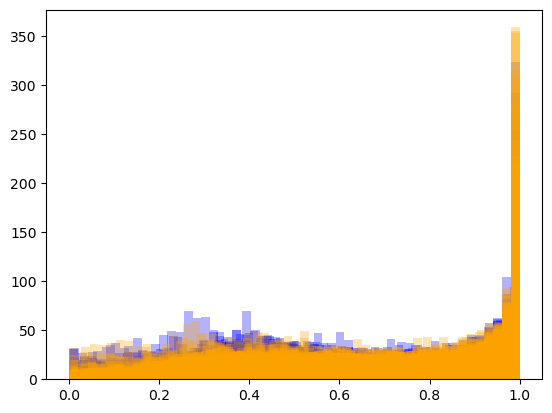

std 10000:  0.0326033684751143
std 12500:  0.025448661837384


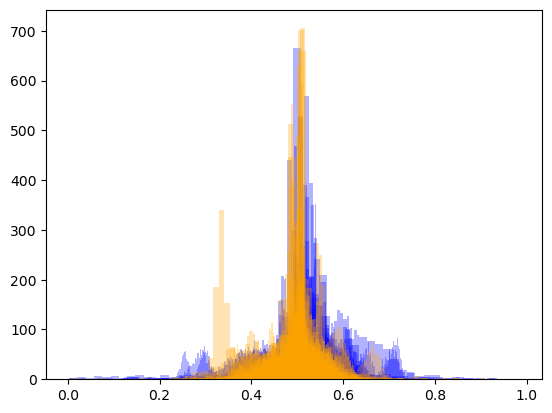

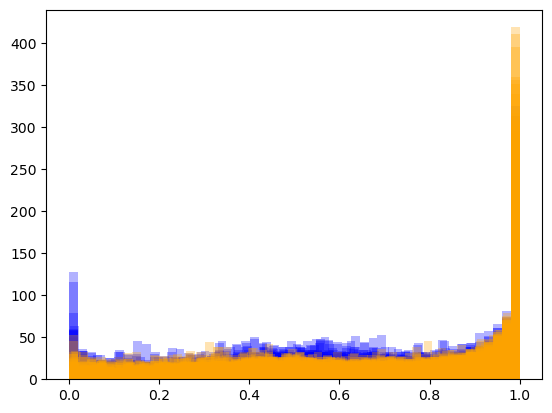

std 10000:  0.04295582163203918
std 12500:  0.03762175054010512


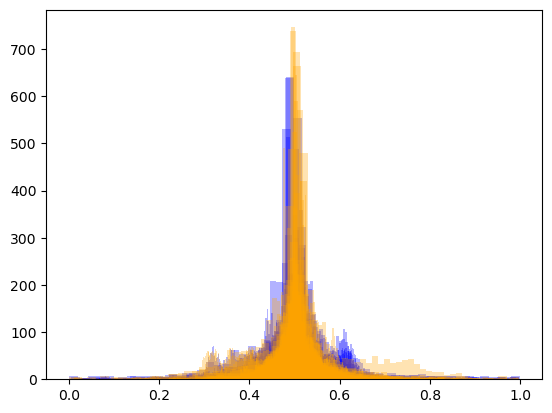

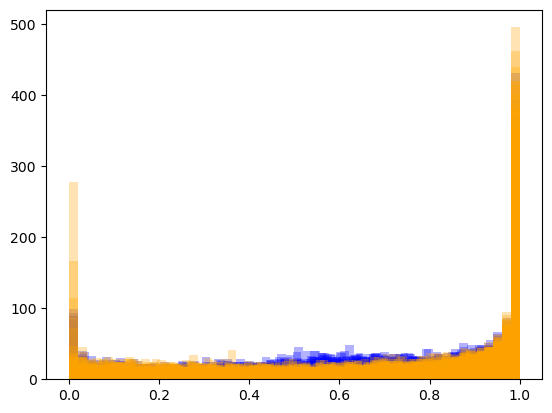

std 10000:  0.0729055460394736
std 12500:  0.06461828048358358


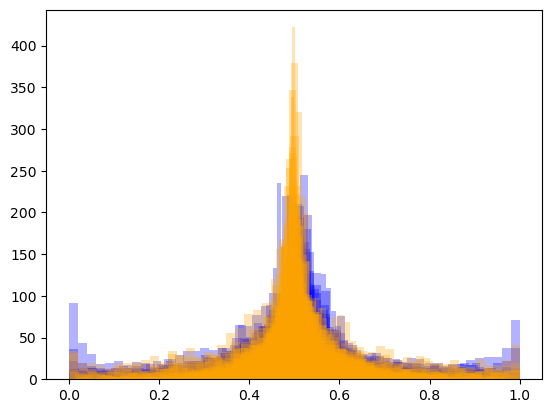

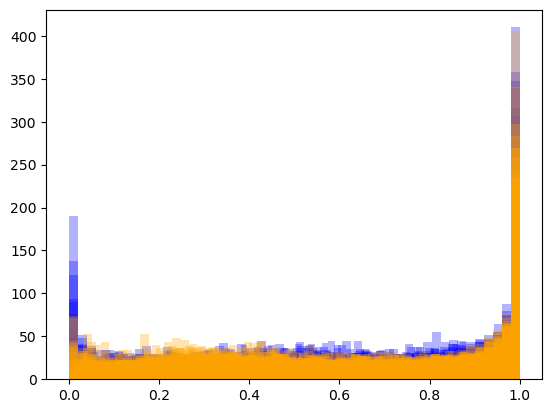

std 10000:  0.11200959117679153
std 12500:  0.10144582465141727


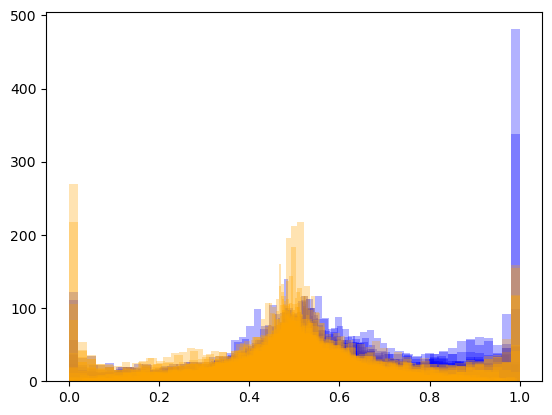

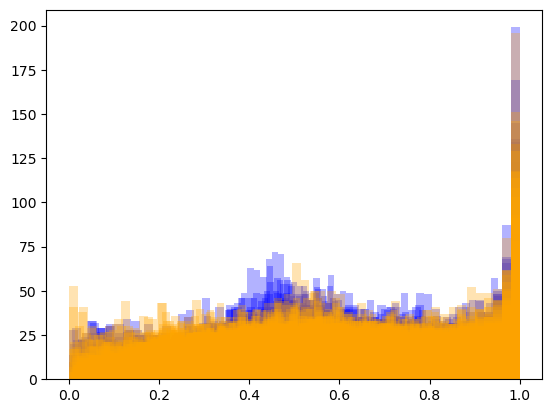

std 10000:  0.10763656162534066
std 12500:  0.08762334487734753


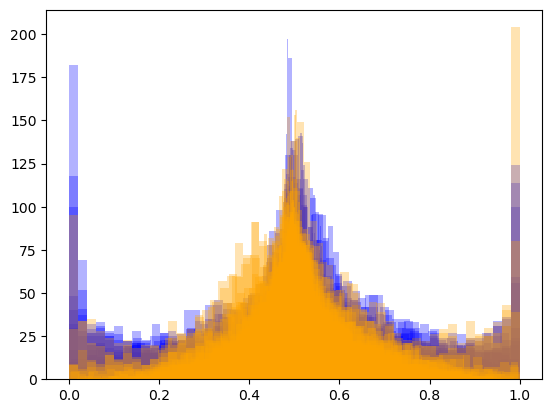

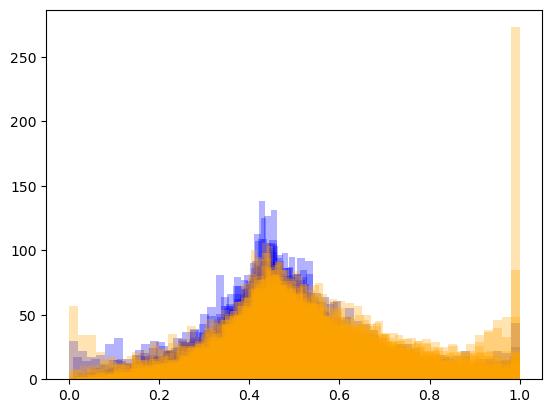

std 10000:  0.054211226170033336
std 12500:  0.04495914109777865


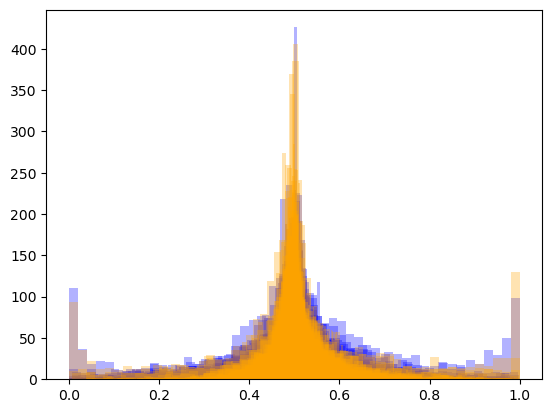

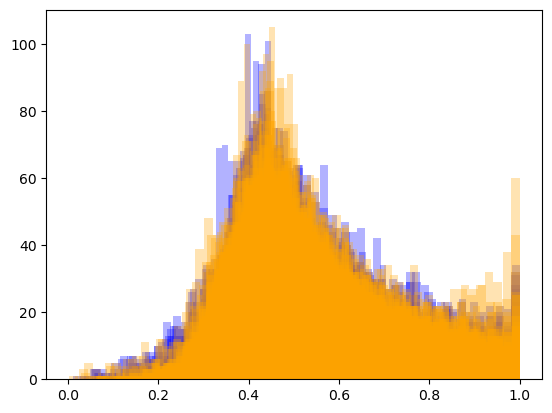

std 10000:  0.02615441823727276
std 12500:  0.0199339259875906


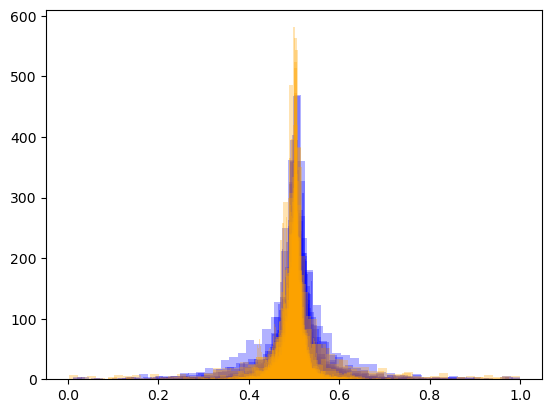

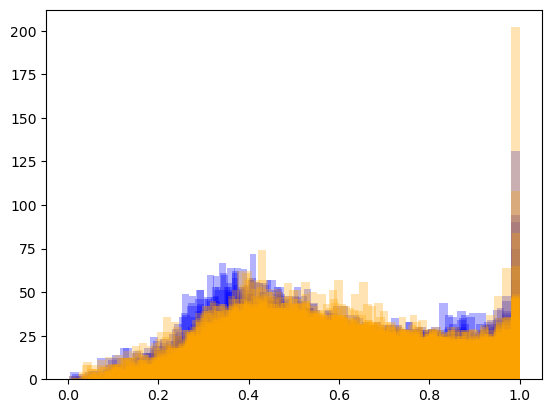

std 10000:  0.019368832509881313
std 12500:  0.015102651092624668


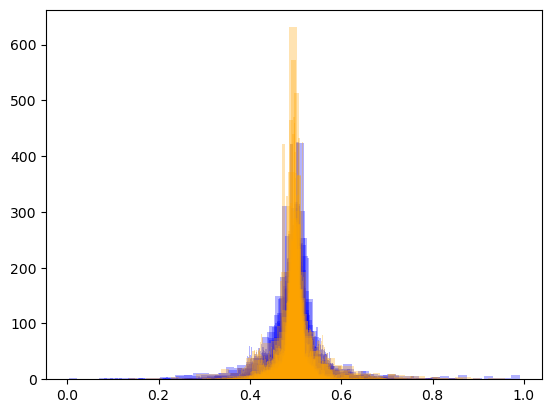

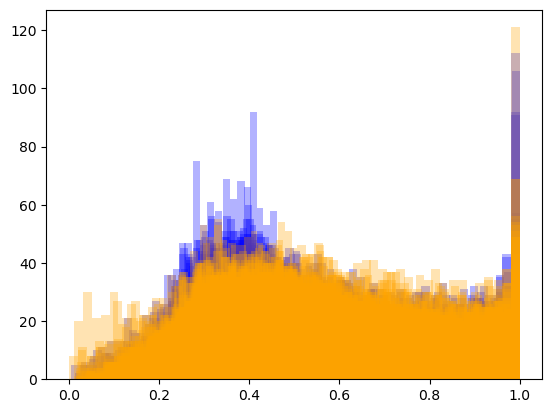

std 10000:  0.016102761224114852
std 12500:  0.012604776982312226


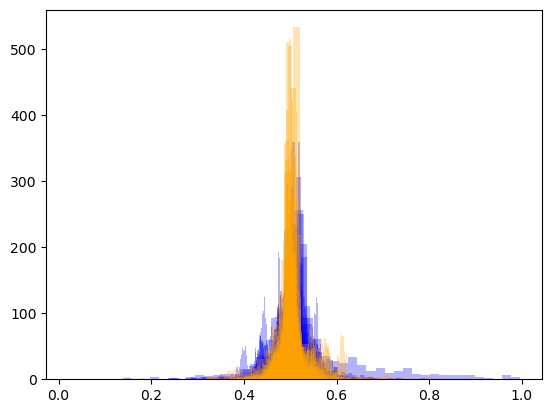

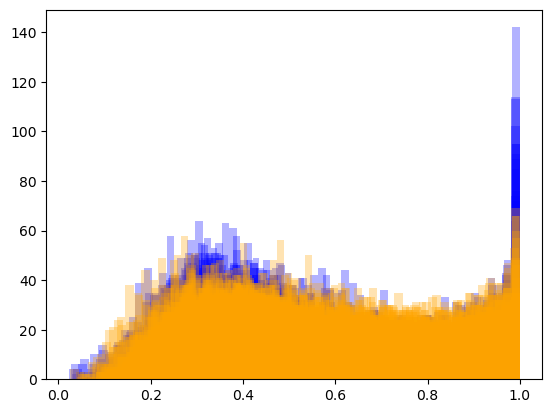

std 10000:  0.015166942775666858
std 12500:  0.010554482214831733


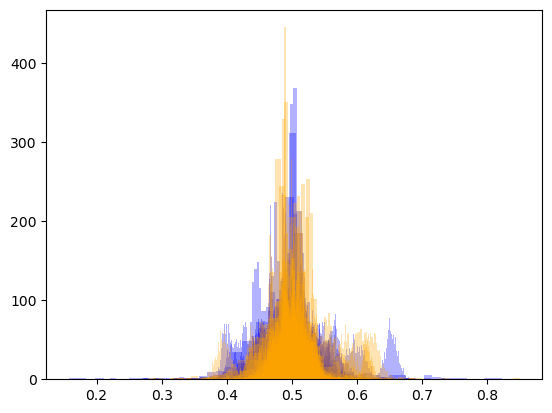

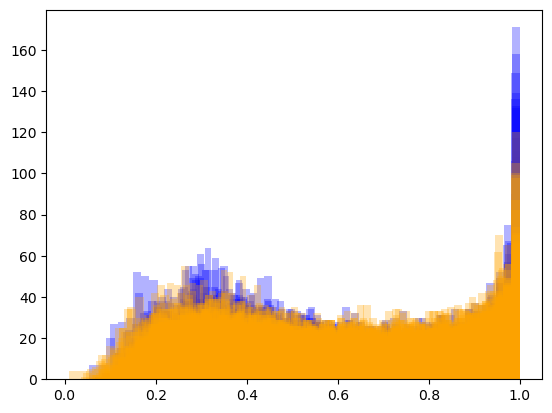

std 10000:  0.014929225123892822
std 12500:  0.009505943723708207


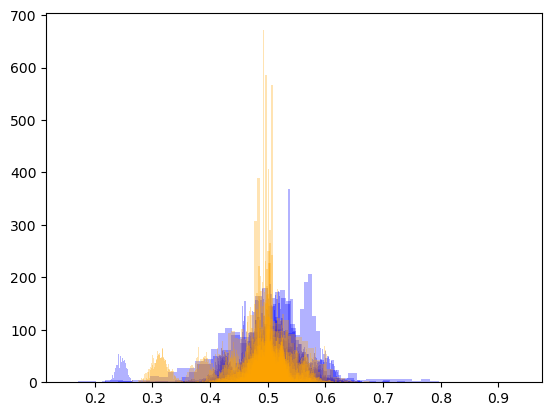

In [25]:
# Plot histograms
n_trials = 1000

plt.rcParams["figure.figsize"] = (10, 4)
for i,g in enumerate(gain_list):
    fig, axs = plt.subplots(1,2)
    for t in range(n_trials):
        axs[0].hist(probas[i][t], alpha=0.3, bins=50, color='orange')
        axs[1].hist(probas_null[i][t], alpha=0.3, bins=50, color='blue')
    axs[0].set_title('Inverse Flow-transformation')
    axs[1].set_title('Multivariate Normal (null hypothesis)')
    plt.suptitle(f'Histogram of predicted probas at x_0, g_0 = {g}')
    plt.show()

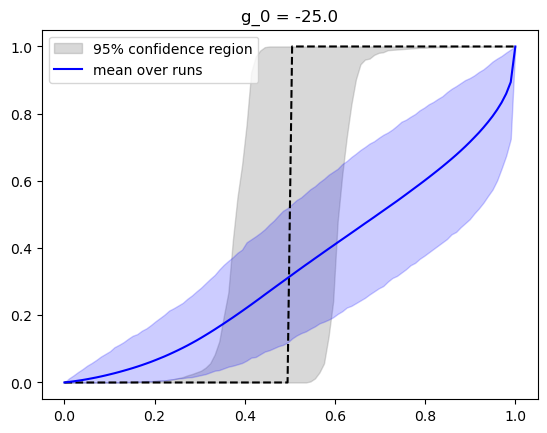

NB samples = 10000
std 0.0326033684751143
test stat:  0.10210065001708997 w_dist:  0.2626715726165754
p-value:  0.067 p_value_w:  0.001
not rejected
rejected (w_dist)

NB samples = 12500
std 0.025448661837384
test stat:  0.11646652201901 w_dist:  0.2754344466194824
p-value:  0.039 p_value_w:  0.001
rejected
rejected (w_dist)


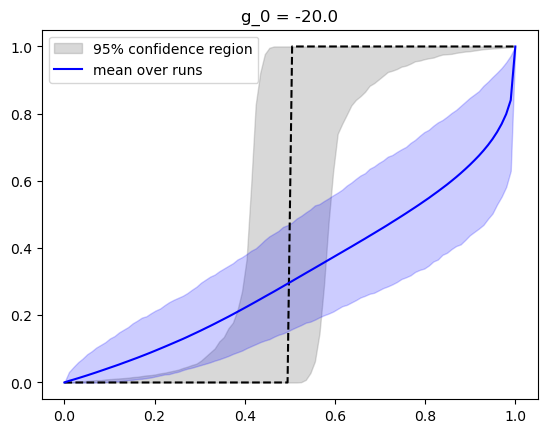

NB samples = 10000
std 0.04295582163203918
test stat:  0.10382447881038998 w_dist:  0.2673684259767747
p-value:  0.027 p_value_w:  0.0
rejected
rejected (w_dist)

NB samples = 12500
std 0.03762175054010512
test stat:  0.13852877253240997 w_dist:  0.3077094507898661
p-value:  0.01 p_value_w:  0.0
rejected
rejected (w_dist)


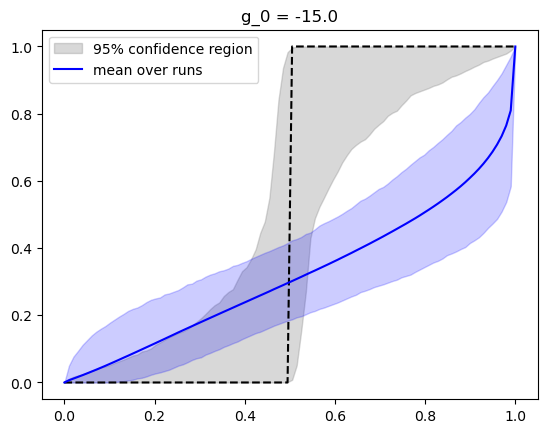

NB samples = 10000
std 0.0729055460394736
test stat:  0.12779727000713997 w_dist:  0.29941532616070593
p-value:  0.002 p_value_w:  0.004
rejected
rejected (w_dist)

NB samples = 12500
std 0.06461828048358358
test stat:  0.15226826873747 w_dist:  0.32856780491236326
p-value:  0.0 p_value_w:  0.003
rejected
rejected (w_dist)


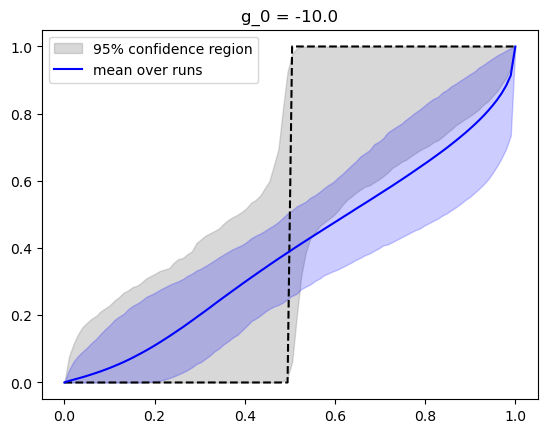

NB samples = 10000
std 0.11200959117679153
test stat:  0.09897781954306005 w_dist:  0.2702056342494576
p-value:  0.068 p_value_w:  0.071
not rejected
not rejected (w_dist)

NB samples = 12500
std 0.10144582465141727
test stat:  0.10322145807230002 w_dist:  0.2748897547180062
p-value:  0.044 p_value_w:  0.042
rejected
rejected (w_dist)


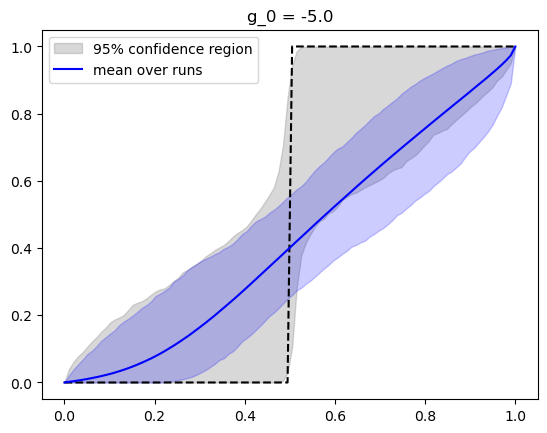

NB samples = 10000
std 0.10763656162534066
test stat:  0.07106713825571001 w_dist:  0.21032367143630898
p-value:  0.119 p_value_w:  0.122
not rejected
not rejected (w_dist)

NB samples = 12500
std 0.08762334487734753
test stat:  0.07719115414830999 w_dist:  0.22514072135722688
p-value:  0.064 p_value_w:  0.068
not rejected
not rejected (w_dist)


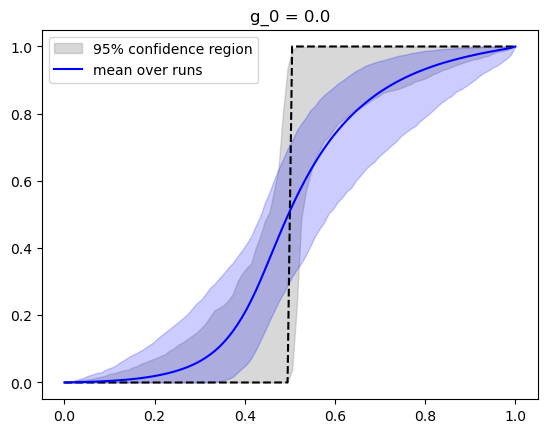

NB samples = 10000
std 0.054211226170033336
test stat:  0.03145126283953999 w_dist:  0.11700763194607858
p-value:  0.076 p_value_w:  0.059
not rejected
not rejected (w_dist)

NB samples = 12500
std 0.04495914109777865
test stat:  0.03358416027641998 w_dist:  0.1239865476036044
p-value:  0.056 p_value_w:  0.035
not rejected
rejected (w_dist)


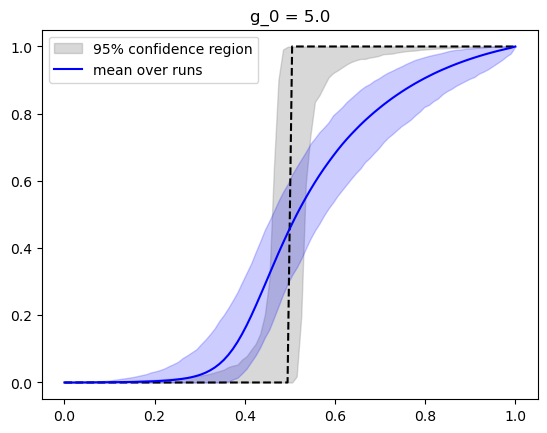

NB samples = 10000
std 0.02615441823727276
test stat:  0.03760466935208997 w_dist:  0.12894386719704978
p-value:  0.035 p_value_w:  0.0
rejected
rejected (w_dist)

NB samples = 12500
std 0.0199339259875906
test stat:  0.037186330754830015 w_dist:  0.12740097921969287
p-value:  0.031 p_value_w:  0.002
rejected
rejected (w_dist)


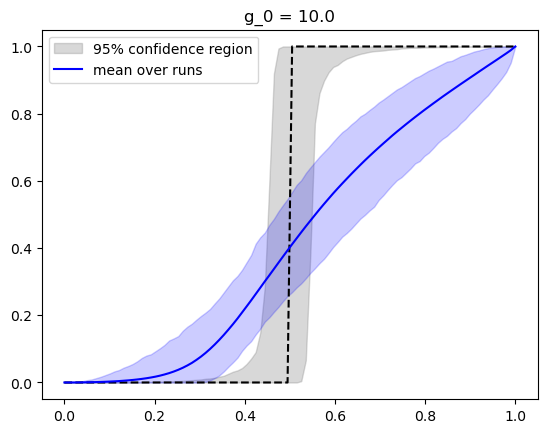

NB samples = 10000
std 0.019368832509881313
test stat:  0.058350789927500014 w_dist:  0.17741167747800296
p-value:  0.018 p_value_w:  0.0
rejected
rejected (w_dist)

NB samples = 12500
std 0.015102651092624668
test stat:  0.05954788151641996 w_dist:  0.1800174801176908
p-value:  0.027 p_value_w:  0.0
rejected
rejected (w_dist)


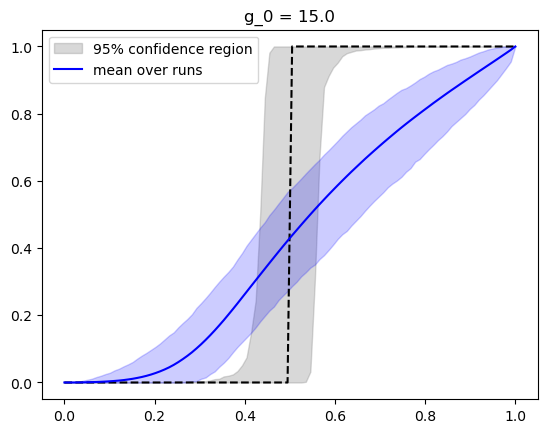

NB samples = 10000
std 0.016102761224114852
test stat:  0.058812362911800004 w_dist:  0.18377654491087458
p-value:  0.026 p_value_w:  0.0
rejected
rejected (w_dist)

NB samples = 12500
std 0.012604776982312226
test stat:  0.06117447289822 w_dist:  0.18793643811123026
p-value:  0.043 p_value_w:  0.0
rejected
rejected (w_dist)


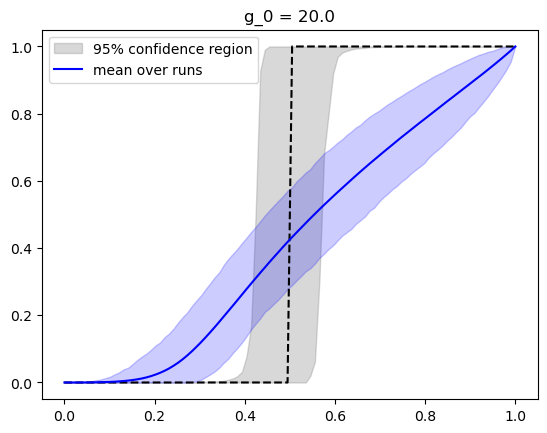

NB samples = 10000
std 0.015166942775666858
test stat:  0.06733239976225998 w_dist:  0.20084081346050425
p-value:  0.062 p_value_w:  0.002
not rejected
rejected (w_dist)

NB samples = 12500
std 0.010554482214831733
test stat:  0.06693688298919004 w_dist:  0.19860972835207183
p-value:  0.051 p_value_w:  0.0
not rejected
rejected (w_dist)


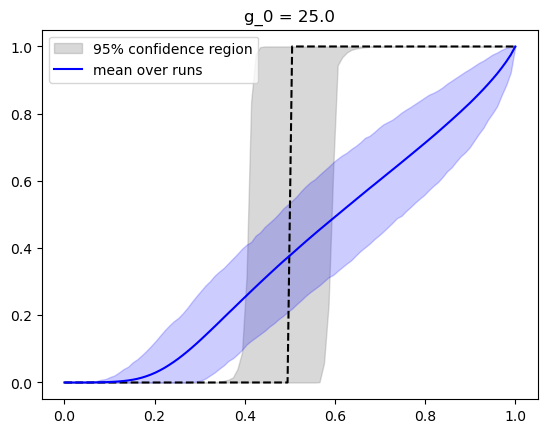

NB samples = 10000
std 0.014929225123892822
test stat:  0.08295230950912993 w_dist:  0.22823945893462644
p-value:  0.05 p_value_w:  0.001
rejected
rejected (w_dist)

NB samples = 12500
std 0.009505943723708207
test stat:  0.08424467955691002 w_dist:  0.2265786420267903
p-value:  0.055 p_value_w:  0.003
not rejected
rejected (w_dist)


In [35]:
# Plot PP-plots and compute test-statistics/p-values
from valdiags.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

plt.rcParams.update(plt.rcParamsDefault)

test_stat = {}
w_dist_mean = {}
p_value = {}
p_value_w = {}
reject = {}
reject_w = {}

for i in range(11):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    # nb samples = 10000
    # plt.plot(alphas, pp_vals_dirac, '--', color='black')

    pp_vals_null = {}
    test_stats_null = {}
    w_dist_null = []
    for t in range(len(probas_null[0])):
        pp_vals_null[t] = pd.Series(PP_vals(probas_null[i][t], alphas))
        test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
        w_dist_null.append(wasserstein_distance([0.5]*1000, probas_null[i][t]))
    
    pp_vals = {}
    w_dist = []
    for t in range(1000):
        pp_vals[t] = pd.Series(PP_vals(probas[i][t], alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, probas[i][t]))

    low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
    up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
    plt.fill_between(alphas, low_null, up_null, label='95% confidence region', color="grey", alpha=0.3)

    low = pd.DataFrame(pp_vals).quantile(0.05/2, axis=1)
    up = pd.DataFrame(pp_vals).quantile(1-0.05/2, axis=1)
    line = pd.DataFrame(pp_vals).mean(axis=1)
    plt.plot(alphas, line, label='mean run', color='blue')
    plt.fill_between(alphas, low, up, color="blue", alpha=0.2)
    plt.legend()
    plt.title(f'PP-plot for g_0 = {gain_list[i]}')
    plt.show()


    test_stat[i] = ((line - pp_vals_dirac) ** 2).sum() / len(alphas)
    p_value[i] = sum(1 * (test_stat[i] < pd.Series(test_stats_null))) / len(test_stats_null)

    w_dist_mean[i] = np.mean(w_dist)
    p_value_w[i] = sum(1 * (w_dist_mean[i] < pd.Series(w_dist_null))) / len(w_dist_null)
    
    print('NB samples = 12500')
    print('std', pd.DataFrame(probas_null[i]).std(axis=1).mean())
    print('test stat: ', test_stat[i], 'w_dist: ', w_dist_mean[i])
    print('p-value: ', p_value[i], 'p_value_w: ', p_value_w[i])
    if p_value[i] <= 0.05:
        print('rejected')
        reject[i] = True
    else:
        print('not rejected')
        reject[i] = False
    
    if p_value_w[i] <= 0.05:
        print('rejected (w_dist)')
        reject_w[i] = True
    else:
        print('not rejected (w_dist)')
        reject_w[i] = False

In [49]:
# Show test results in dataframe
df_results = {}
df_results['TV_dist'] = pd.DataFrame({
    'test_stat': test_stat, 
    'p_value': p_value, 
    'rejected': reject 
})
df_results['w_dist'] = pd.DataFrame({
    'test_stat': w_dist_mean, 
    'p_value': p_value_w, 
    'rejected': reject_w 
})
pd.concat({k: pd.DataFrame(v).T for k, v in df_results.items()}, axis=0)

The TV_dist fails to reject more often than w_dist, which makes w_dist more powerful (this can also be seen in the section about "precision under the null-hypothsis - cal-set choice).

### Neurips images


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


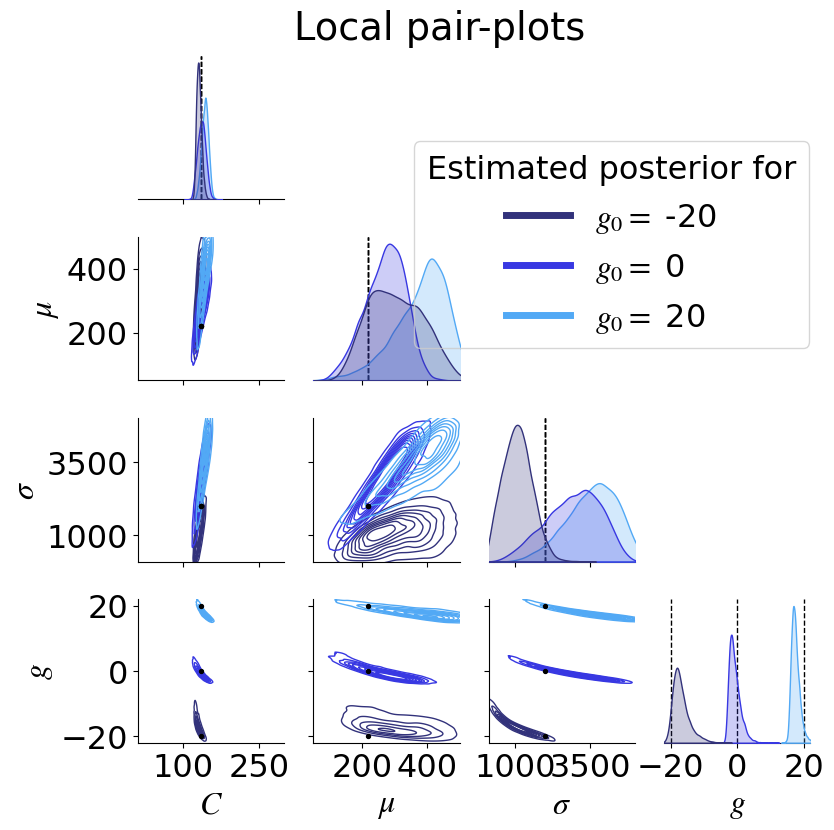

In [18]:
from plots_neurips2022 import plot_pairgrid_with_groundtruth

# Plot learned posteriors with true parameters 
cases = [{'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -20, 'xobs_id': 1, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -15, 'xobs_id': 2, 'n_sim': B,'single_rec': SINGLE_REC},
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 0, 'xobs_id': 5, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 15, 'xobs_id': 8, 'n_sim': B,'single_rec': SINGLE_REC},]
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 20, 'xobs_id': 9, 'n_sim': B,'single_rec': SINGLE_REC},]

posteriors = {}
context = {}
theta_true_list = []
for exp in cases:
    # filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    # filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}_new.pkl"
    if exp['n_extra'] > 0:
        filename_xobs = filename[:-4]+f"_single_rec_{exp['single_rec']}.pkl"
    
    label = r"$g_0 =$"+f" {exp['gt_gain']}"
    posteriors[label]= posterior #torch.load(filename_posterior)
    # context[label] = torch.load(filename_xobs)
    context[label] = x_obs_list[exp['xobs_id']][None,:,:]
    theta_true_list.append(np.array([c, mu, sigma, exp['gt_gain']])) 

color_dict = dict(zip(list(posteriors.keys()), ['#32327B', '#3838E2', '#52A9F5']))
# color_dict = dict(zip(list(posteriors.keys()), ['blue','purple', '#D90368', '#FFA500','gold']))

g = plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=theta_true_list,
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Estimated posterior for'
)

g.savefig(PATH_EXPERIMENT+'images_neurips/parigrid.pdf')

/var/folders/56/162hrf1x5hg70vm0swrrv1_80000gn/T/ipykernel_766/4082816926.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/var/folders/56/162hrf1x5hg70vm0swrrv1_80000gn/T/ipykernel_766/4082816926.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


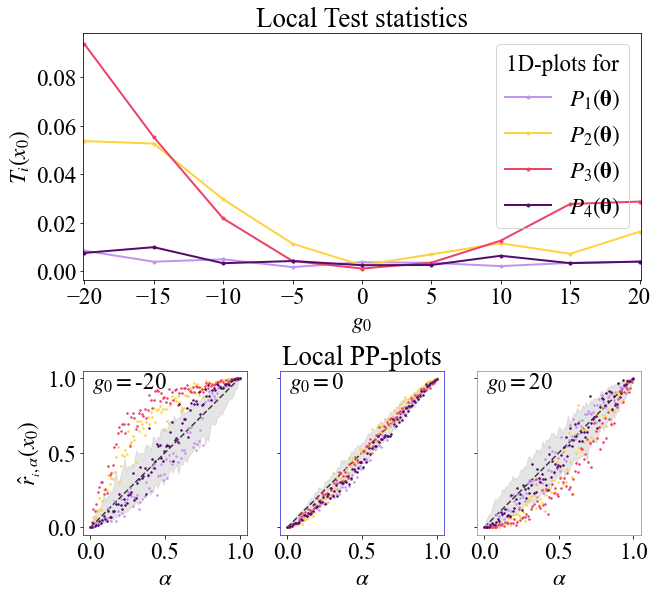

In [100]:
from plots_neurips2022 import multi_local_consistency
colors = []
fig = multi_local_consistency(lct_base_t1000_na100_path_list, gain_list, colors_pit, labels_pit, r_alpha_null_list=r_alpha_null_list, conf_alpha=0.05/4) # bonferonni correction
plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')

## OLD EXPERIMENTS

### Multal independance of the PIT-covariates: estimate the local correlation coefficients


#### Global PIT

In [ ]:
df_flow_transform = pd.DataFrame({
'Z_1': posterior._transform(theta_cal, context=x_cal)[0][:, 0].detach().numpy(),
'Z_2' : posterior._transform(theta_cal, context=x_cal)[0][:, 1].detach().numpy(),
'Z_3' : posterior._transform(theta_cal, context=x_cal)[0][:, 2].detach().numpy(),
'Z_4' : posterior._transform(theta_cal, context=x_cal)[0][:, 3].detach().numpy()
})
corr_12 = df_flow_transform.corr()['Z_1'][1]
corr_13 = df_flow_transform.corr()['Z_1'][2]
corr_14 = df_flow_transform.corr()['Z_1'][3]
corr_23 = df_flow_transform.corr()['Z_2'][2]
corr_24 = df_flow_transform.corr()['Z_2'][3]
corr_34 = df_flow_transform.corr()['Z_3'][3]
print(np.linalg.eig(df_flow_transform.cov())[0])
df_flow_transform.cov()

[0.74859784 0.78710539 0.98237891 0.92151598]


Z_1       Z_2       Z_3       Z_4
Z_1  0.796723 -0.034081 -0.023824  0.005703
Z_2 -0.034081  0.920577  0.015333 -0.001241
Z_3 -0.023824  0.015333  0.971726  0.013367
Z_4  0.005703 -0.001241  0.013367  0.750571

In [ ]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_null = []
eig_vals_null = []
null_df_list = []
for t in range(n_trials):
    null_df_list.append(pd.DataFrame({
        'Z_1': norm().rvs(B_PRIME),
        'Z_2': norm().rvs(B_PRIME),
        'Z_3': norm().rvs(B_PRIME),
        'Z_4': norm().rvs(B_PRIME),
    }))
    corr_null.append(null_df_list[-1].corr()['Z_1'][1])
    eig_vals_null.append(np.linalg.eig(null_df_list[-1].cov())[0])

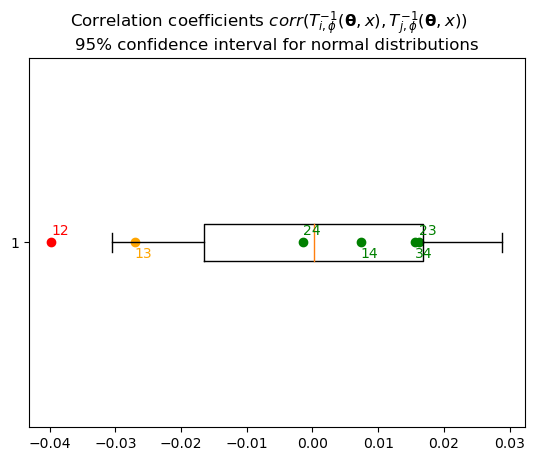

In [ ]:
import matplotlib.cbook as cbook

data = corr_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.text(corr_12, 1.02, '12', color='red')
plt.scatter(corr_12, 1, color='red')
plt.text(corr_13, 0.96, '13', color='orange')
plt.scatter(corr_13, 1, color='orange')
plt.text(corr_14, 0.96, '14', color='green')
plt.scatter(corr_14, 1, color='green')
plt.text(corr_23, 1.02, '23', color='green')
plt.scatter(corr_23, 1, color='green')
plt.text(corr_24, 1.02, '24', color='green')
plt.scatter(corr_24, 1, color='green')
plt.text(corr_34, 0.96, '34', color='green')
plt.scatter(corr_34, 1, color='green')

# plt.legend()
plt.title('95% confidence interval for normal distributions')
plt.suptitle(r'Correlation coefficients $corr(T_{i,\phi}^{-1}(\mathbf{\theta}, x),T_{j,\phi}^{-1}(\mathbf{\theta}, x))$')
plt.show()

#### Local PIT

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


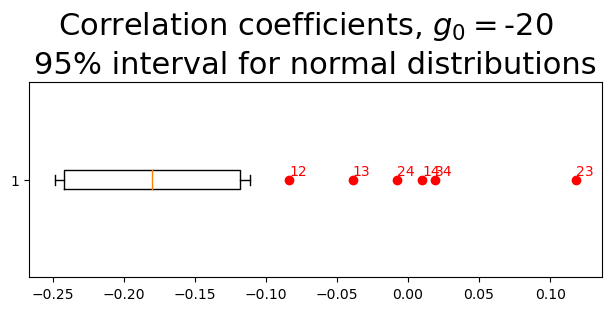

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


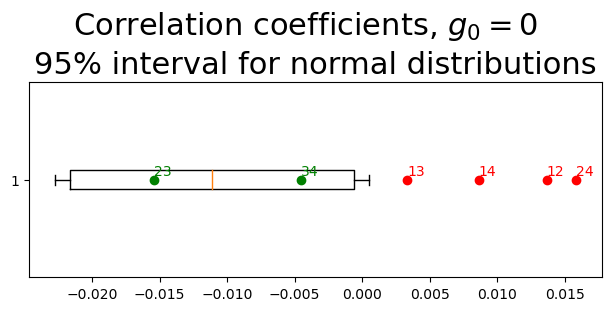

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


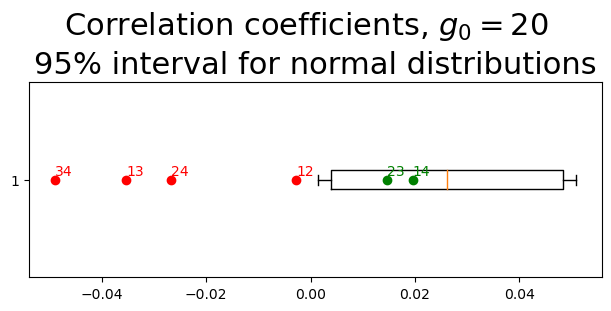

In [ ]:
from valdiags.localPIT_regression import local_correlation_regression
import matplotlib.cbook as cbook
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (6, 3)

df_flow_transform = pd.DataFrame({
'Z_1': posterior._transform(theta_cal, context=x_cal)[0][:, 0].detach().numpy(),
'Z_2' : posterior._transform(theta_cal, context=x_cal)[0][:, 1].detach().numpy(),
'Z_3' : posterior._transform(theta_cal, context=x_cal)[0][:, 2].detach().numpy(),
'Z_4' : posterior._transform(theta_cal, context=x_cal)[0][:, 3].detach().numpy()
})

n_trials = 2

for ind, gain in zip([1, 5, 9], [-20, 0, 20]):
    results_mean = {"12": 0, "13": 0, "14": 0, "23": 0, "24": 0, "34": 0}
    for k in range(2):
        regs, results = local_correlation_regression(
            df_flow_transform, x_cal[:, :, 0], x_eval=x_obs_list[ind][None, :, 0]
        )
        results_mean["12"] += results["12"] / 10
        results_mean["13"] += results["13"] / 10
        results_mean["14"] += results["14"] / 10
        results_mean["23"] += results["23"] / 10
        results_mean["24"] += results["24"] / 10
        results_mean["34"] += results["34"] / 10
    results_null = []
    for k in range(n_trials):
        df_null = pd.DataFrame(
            {
                "Z_1": norm().rvs(len(x_cal)),
                "Z_2": norm().rvs(len(x_cal)),
                "Z_3": norm().rvs(len(x_cal)),
                "Z_4": norm().rvs(len(x_cal)),
            }
        )
        regs_null, result_null = local_correlation_regression(
            df_null, x_cal[:, :, 0], x_eval=x_obs_list[ind][None, :, 0]
        )
        results_null.append(result_null["12"])

    data = np.array(results_null)
    stats = cbook.boxplot_stats(data)[0]
    stats["q1"] = np.quantile(data, 0.05)
    stats["q3"] = np.quantile(data, 0.95)
    stats["whislo"] = min(data)
    stats["whishi"] = max(data)
    labels = ["12", "13", "14", "23", "24", "34"]

    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    bp = ax.bxp([stats], widths=0.1, vert=False, showfliers=False,)
    for label in labels:
        if stats["q1"] <= results_mean[label] <= stats["q3"]:
            color = "green"
        elif stats["whislo"] <= results_mean[label] <= stats["whishi"]:
            color = "orange"
        else:
            color = "red"
        plt.text(results_mean[label], 1.02, label, color=color)
        plt.scatter(results_mean[label], 1, color=color)

    # plt.legend()
    plt.title("95% interval for normal distributions", fontsize=22)
    plt.suptitle(r"Correlation coefficients, $g_0=$" + str(gain), fontsize=22)
    plt.show()


- variability of the regression method
- takien into account in the test by using the same regression method for null hyp: large conf interval
- make it less: mean over 10 regressors and more trials for null-hyp (100)

### Choice of regression model for Local PIT-cdf

#### 1. Recovery of the true Expected PIT 

We will compare the baseline method and these selected HG-regressors in terms of recovery of the true PIT values of our flow on an evaluation dataset of the joint $\{(\Theta_i, X_i), i=1,\dots, n_{eval}\}$.

The estimated local PIT values are:
$$\hat{r}_{\alpha}(X) \approx \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

We can compute the expected estimated PIT values over the evaluation dataset and compare them to the real expected PIT values:

$$\hat{E}(\alpha) = \frac{1}{n_{eval}} \sum_{i=1}^{n_{eval}} \hat{r}_{\alpha}(X_i) \quad \text{vs.} \quad E(\alpha) = \frac{1}{n_{eval}}\sum_{i=1}^{n_{eval}} \mathbb{1}_{\{\text{PIT}(\Theta_i, X_i ; q_{\phi}) \leq \alpha\}}$$

We do this by computing the MSE over a grid of alpha values `np.linspace(0,0.99,m)` (with `m=100`):

$$ \frac{1}{m}\sum_{t=1}^{m} (\hat{E}(\alpha_t) - E(\alpha_t))^2$$

We compute the mean and std over 10 models per regression method.

In [10]:
# TRUE EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_double_prime']['theta'], datasets['B_double_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_test, x_test, posterior, feature_transform=identity
)

In [10]:
from diagnostics.pp_plots import PP_vals

nb_classifiers = 10
method_names = ['baseline', 'hg10','hg20','hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90', 'hg100', 'hg110', 'hg120']

euc_dist_list = {}
for method_name in method_names:
    euc_dist_list[method_name] = {}
    # Load Estimated Expected PIT values 
    E_hat_loaded = torch.load(PATH_EXPERIMENT+f'reg_eval/expected_pit_list_{method_name}.pkl')

    alphas = np.linspace(0,0.99,100)

    for i in range(1,5):
        # True Expected PIT values 
        E = PP_vals(flow_joint_pit_values[i-1], alphas)
        euc_dist_list[method_name][f'dim_{i}'] = {}
        euc_dist_list_c =[]
        for c in range(nb_classifiers):
            euc_dist_list_c.append(np.mean((E_hat_loaded[c][f'dim_{i}'] - E)**2))

        euc_dist_list[method_name][f'dim_{i}']['mean'] = np.mean(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}']['std'] = np.std(euc_dist_list_c)
        euc_dist_list[method_name][f'dim_{i}'] = pd.Series(euc_dist_list[method_name][f'dim_{i}'])

In [14]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'
method_names = ['baseline', 'hg10','hg20','hg30', 'hg40', 'hg50', 'hg60', 'hg70', 'hg80', 'hg90', 'hg100', 'hg110', 'hg120']

max_iter_list = np.linspace(10,120,12,dtype=int)

# xticks =[]
# for it in range(1,10):
#     xticks+=['',str(it*20)]

means = np.array([np.mean([euc_dist_list[method_name][f'dim_{i}']['mean'] for i in range(1,5)]) for method_name in method_names[1:]])
stds = np.array([np.mean([euc_dist_list[method_name][f'dim_{i}']['std'] for i in range(1,5)]) for method_name in method_names[1:]])
plt.plot(max_iter_list, means, marker='x')
plt.fill_between(max_iter_list, means-stds, means+stds, alpha=0.1)

mean_base = np.mean([euc_dist_list['baseline'][f'dim_{i}']['mean'] for i in range(1,5)])
std_base = np.mean([euc_dist_list['baseline'][f'dim_{i}']['std'] for i in range(1,5)])
plt.plot(max_iter_list, [mean_base]*len(max_iter_list), color='black', label='baseline mean')
plt.plot(max_iter_list, [mean_base+std_base]*len(max_iter_list), '--', color='black', label='baseline +std')
plt.plot(max_iter_list, [mean_base-std_base]*len(max_iter_list), '--', color='black', label='baseline -std')
plt.legend()
# plt.xticks(max_iter_list, xticks)
plt.xlabel('max_iter', fontsize=15)
plt.ylabel(r'$MSE(\hat{E}, E)$', fontsize=15)
plt.suptitle('MSE between estimated and true expected PIT', fontsize=18)
plt.title('Mean and STD over 10 models per method',fontsize=10)
plt.show()

NameError: name 'euc_dist_list' is not defined

All HG-methods are better than the baseline (lower MSE and less variance). Low variance is important for p-value computation.

#### 2. Comparison of Test Statistics under the null hypothesis

The goal is to find the best regressor $\hat{r}_{\alpha}(X)$ to estimate the local PIT values defined for $\alpha \in [0,1]$ by the c.d.f of the PIT at $X$:
$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; q_{\phi}) \leq \alpha\}}\mid X]$$

Under null hypothesis of local consistency at $x_0$, the PIT at $X=x_0$ follows a uniform distribution, i.e. we have 
$$H_0 : \big(q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0) \big) \quad  \Rightarrow \quad  r_{\alpha}(x_0) = \alpha, \quad \forall \alpha \in [0,1].$$ 

The deviance from the null hypothesis is quantified by the test statistic: 
$$T_m(x_0) = \frac{1}{m}\sum_{t=1}^m (r_{\alpha_t}(x_0)-\alpha_t)^2.$$

A good regressor should be able to correctly represent the null hypothesis: it should predict the identity function for a locally consistent estimator (the test statistic should be 0):
$$q_{\phi}(\Theta \mid x_0) = p(\Theta \mid x_0)  \quad  \Rightarrow \quad  \hat{r}_{\alpha}(x_0) = \alpha, \forall \alpha \in [0,1] \quad  \Rightarrow \quad  \hat{T}_m(x_0) = 0$$


Theoretically for uniform PIT-values $U$, $\mathbb{P}(U \leq \alpha \mid X) = \alpha$. So for a $X=x_0$, we should get test statistics close to zero (not equal because we are in a finite sample regime). 

In practice, we can therefore compare regression methods by comparing test statistics obtained under the null hypothesis, i.e. for uniformly distributed PIT-values, on average over several trials:

For every trial: 
- generate $U_i \sim \mathcal{U}(0,1)$ 
- regress $U_i$ on $X_i$ to learn $\hat{r}_{\alpha}(X)$ under $H_0$
- compute the test statistic for $X=x_0$ 

We compute the average test statistic over all trials (100).

We plot the mean nd std over different $x_0$ s.t. $g_0 \in [-15,15]$ to avoid border effects. 


In [238]:
# load the baseline regressors trained on uniform PIT values (100 trials and 21 alpha values)
path_lct = PATH_EXPERIMENT+f'lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/'
path_lct_baseline = path_lct+f'baseline/lct_results_baseline_mlp_nalpha_21_ntrials_100_n_alphas_21'

# load the histgradboost regressors trained on uniform PIT values (100 trials) and evaluated on 21 alpha values
path_lct_max_iter = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/max_iter_exp/lct_results_sample50_histgrad90_"

gain_list = np.linspace(-15,15,7,dtype=int)
# gain_list = [0]
max_iter_list = np.linspace(10,200,20,dtype=int)

T_null_base = []
test_stats_dict = {}
for g in gain_list:
    path_lct_baseline_g0 = path_lct_baseline+f'_gain_{g}.pkl'

    r_alpha_null_list_base_g0 = torch.load(path_lct_baseline_g0)['r_alpha_null_list']
    n_trials = len(r_alpha_null_list_base_g0)
    T_base_t100_na21_mean = 0
    for i in range(1,5):
        T_base_t100_na21 = []
        for t in range(n_trials):
            T_base_t100_na21.append(compute_test_statistic(r_alpha_null_list_base_g0[t][f'dim_{i}']))
        T_base_t100_na21_mean += np.mean(T_base_t100_na21)
    T_base_t100_na21_mean /=4
    T_null_base.append(T_base_t100_na21_mean)

    test_stats_dict[g] = {}
    for i in range(1,5):
        test_stats_dict[g][f'dim_{i}'] = {}
        test_stats_mean ={}
        test_stats_std = {}
        for it in max_iter_list:
            lct_max_iter_path_g = path_lct_max_iter + f"maxiter_{it}_ntrials_100_n_alphas_21_gain_{g}.pkl"

            r_alpha_null_list_g = torch.load(lct_max_iter_path_g)['r_alpha_null_list']
            n_trials = len(r_alpha_null_list_g)
            T_values = []
            for t in range(n_trials):
                T_values.append(compute_test_statistic(r_alpha_null_list_g[t][f'dim_{i}']))
            test_stats_mean[it] = np.mean(T_values)
            test_stats_std[it] = np.std(T_values)
        test_stats_dict[g][f'dim_{i}']['mean'] = pd.Series(test_stats_mean)
        test_stats_dict[g][f'dim_{i}']['std'] = pd.Series(test_stats_std)

T_dim ={}  
for i in range(1,5):
    T_dim[f'dim_{i}'] = {}
    T_dim[f'dim_{i}']['mean'] = {}
    T_dim[f'dim_{i}']['std'] = {}
    for it in max_iter_list:
        T_i_it = []
        for g in gain_list:
            T_i_it.append(test_stats_dict[g][f'dim_{i}']['mean'][it])
        T_dim[f'dim_{i}']['mean'][it] = np.mean(T_i_it)
        T_dim[f'dim_{i}']['std'][it] = np.std(T_i_it)
    T_dim[f'dim_{i}']['mean'] = pd.Series(T_dim[f'dim_{i}']['mean'])
    T_dim[f'dim_{i}']['std'] = pd.Series(T_dim[f'dim_{i}']['std'])

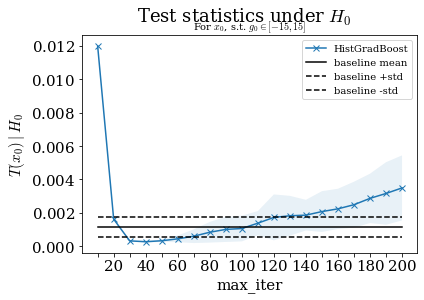

In [240]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

max_iter_list = np.linspace(10,200,20,dtype=int)

xticks =[]
for it in range(1,11):
    xticks+=['',str(it*20)]

i = 1 # same for every dim so we choose one 
T_dim[f'dim_{i}']['mean'].plot(marker='x', label='HistGradBoost')
error = T_dim[f'dim_{i}']['std']
y = T_dim[f'dim_{i}']['mean']
plt.fill_between(max_iter_list, y-error, y+error, alpha=0.1)

plt.plot(max_iter_list, [np.mean(T_null_base)]*len(max_iter_list), color='black', label='baseline mean')
plt.plot(max_iter_list, [np.mean(T_null_base)+np.std(T_null_base)]*len(max_iter_list), '--', color='black', label='baseline +std')
plt.plot(max_iter_list, [np.mean(T_null_base)-np.std(T_null_base)]*len(max_iter_list), '--', color='black', label='baseline -std')
plt.legend()
plt.xticks(np.linspace(10,200,20), xticks)
plt.xlabel('max_iter', fontsize=15)
plt.ylabel(r'$T(x_0) \mid H_0$', fontsize=15)
plt.suptitle(r'Test statistics under $H_0$', fontsize=18)
plt.title(r'For $x_0$, s.t. $g_0 \in [-15,15]$', fontsize=10)
plt.show()

Valid `max_iter` values for our `HistGradBoostClassifier` with default parameters go from 30 to 90/100. They give lower test statistics under the null than the baseline while keeping a low variance over the trials.

We will check which one is better at estimating PIT values for complex data distributions that are not calibrated.  Intuitively this will be the one with the highest number of iterations (i.e. max_iter = 90/100). 

We do this by looking at the evolution of the LCT test statistic over the gain parameter space. It should be 
- in a well defined U-shape 
- as small as possible in $g_0 = 0$, where we expect the test to pass

In [11]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t1000_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{1000}_n_alphas_{100}"
)  # no pvalues, used to plot pp-pplot

path_lct_hg30_t1000_na100 = (
    path_lct + f"histgrad30/lct_results_sample50_histgrad90_maxiter_30_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_hg90_t1000_na100 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline

path_lct_hg100_t1000_na100 = (
    path_lct + f"histgrad100/lct_results_sample50_histgrad90_maxiter_100_ntrials_{1000}_n_alphas_{100}"
)  # more trials for pvalues nd more alpha values, not available for baseline


gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t1000_na100_path_list = []
lct_hg30_t1000_na100_path_list = []
lct_hg90_t1000_na100_path_list = []
lct_hg100_t1000_na100_path_list = []


for g in gain_list:
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg30_t1000_na100_path_list.append(path_lct_hg30_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg90_t1000_na100_path_list.append(path_lct_hg90_t1000_na100 + f"_gain_{g}.pkl")
    lct_hg100_t1000_na100_path_list.append(path_lct_hg100_t1000_na100 + f"_gain_{g}.pkl")


    

from diagnostics.multi_local_test import get_lct_results

df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

df_hg90_t1000_na100 = get_lct_results(lct_hg90_t1000_na100_path_list, pvalues=False)
df_hg90_t1000_na100.index = gain_list

df_hg30_t1000_na100 = get_lct_results(lct_hg30_t1000_na100_path_list, pvalues=False)
df_hg30_t1000_na100.index = gain_list

df_hg100_t1000_na100 = get_lct_results(lct_hg100_t1000_na100_path_list, pvalues=False)
df_hg100_t1000_na100.index = gain_list

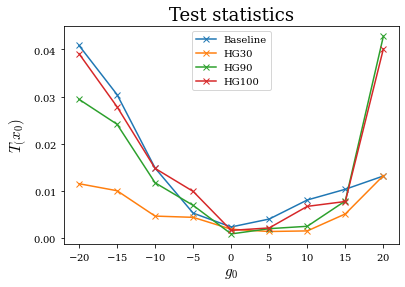

In [12]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

colors=["orange", "red", "purple", "blue"]
labels = [r'$\Theta_1 = C$', r'$\Theta_2 = \mu$', r'$\Theta_3 = \sigma$', r'$\Theta_4 = g$']

plt.plot(gain_list, np.mean([df_base_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='Baseline')
plt.plot(gain_list, np.mean([df_hg30_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG30')
plt.plot(gain_list, np.mean([df_hg90_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG90')
plt.plot(gain_list, np.mean([df_hg100_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG100')

# plt.plot(np.mean([df_hg100_t1000_na100[f'dim_{i}'] for i in range(1,5)], axis=0), marker='x', label='HG100')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_(x_0)$', fontsize=15)
plt.title(r'Test statistics', fontsize=18)
plt.show()
plt.show()

The HG90 seems best. 

##### Plot p-values

In [250]:
path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t100_na21 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_21_ntrials_{100}_n_alphas_{21}"
)  # with pvalues

path_lct_hg90_t100_na21 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{100}_n_alphas_{21}"
)  # with pvalues, used to compare to baseline
path_lct_hg90_t1000_na21 = (
    path_lct + f"histgrad90/lct_results_sample50_histgrad90_ntrials_{1000}_n_alphas_{21}"
)  # more trials for pvalues, not available for baseline

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t100_na21_path_list = []

lct_hg90_t100_na21_path_list = []
lct_hg90_t1000_na21_path_list = []

for g in gain_list:
    lct_base_t100_na21_path_list.append(path_lct_base_t100_na21 + f"_gain_{g}.pkl")

    lct_hg90_t100_na21_path_list.append(path_lct_hg90_t100_na21 + f"_gain_{g}.pkl")
    lct_hg90_t1000_na21_path_list.append(path_lct_hg90_t1000_na21 + f"_gain_{g}.pkl")

In [253]:
df_base_t100_na21 = get_lct_results(lct_base_t100_na21_path_list)
df_base_t100_na21.columns = df_base_t100_na21.columns.str.split('__', expand=True)
df_base_t100_na21.index = gain_list

df_hg90_t100_na21 = get_lct_results(lct_hg90_t100_na21_path_list)
df_hg90_t100_na21.columns = df_hg90_t100_na21.columns.str.split('__', expand=True)
df_hg90_t100_na21.index = gain_list

df_hg90_t1000_na21 = get_lct_results(lct_hg90_t1000_na21_path_list)
df_hg90_t1000_na21.columns = df_hg90_t1000_na21.columns.str.split('__', expand=True)
df_hg90_t1000_na21.index = gain_list



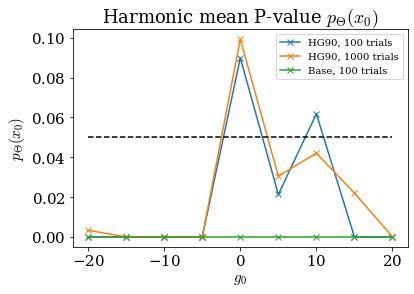

In [260]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg90_t100_na21['p_values']['hmean'], marker='x', label='HG90, 100 trials')
plt.plot(gain_list, df_hg90_t1000_na21['p_values']['hmean'], marker='x', label='HG90, 1000 trials')
plt.plot(gain_list, df_base_t100_na21['p_values'][f'hmean'], marker='x', label='Base, 100 trials')
plt.legend()
plt.plot(gain_list,np.ones_like(gain_list)*0.05, '--', color='black')
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Harmonic mean P-value $p_{\Theta}(x_0)$', fontsize=18)
plt.show()

##### Plot Multi-Test results (not hmean)

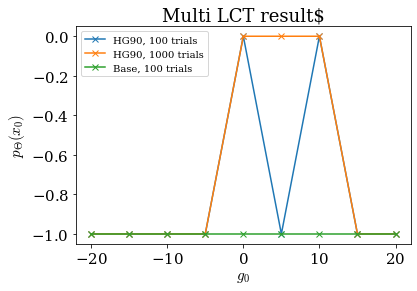

In [261]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'

gain_list = np.linspace(-20,20,9)

# HISTGRAD 
plt.plot(gain_list, df_hg90_t100_na21['lct_results']['combined']*-1, marker='x', label='HG90, 100 trials')
plt.plot(gain_list, df_hg90_t1000_na21['lct_results']['combined']*-1, marker='x', label='HG90, 1000 trials')
plt.plot(gain_list, df_base_t100_na21['lct_results']['combined']*-1, marker='x', label='Base, 100 trials')
plt.legend()
plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$p_{\Theta}(x_0)$', fontsize=15)
plt.title(r'Multi LCT result$', fontsize=18)
plt.show()

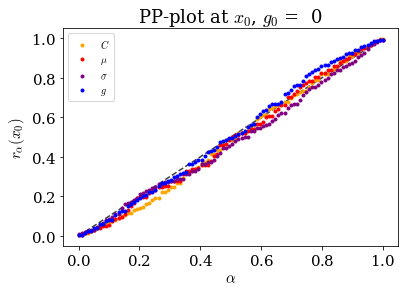

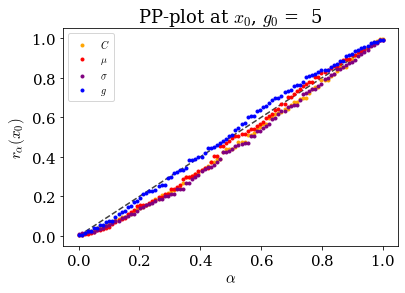

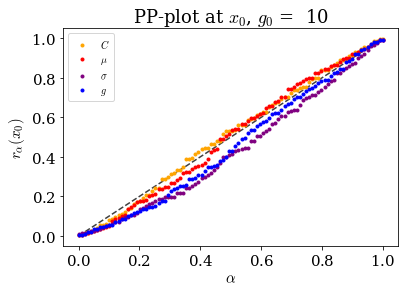

In [263]:
# pp-plots for accepted x_0
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in [0,5,10]]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg90_t1000_na100_path_list[4:7]] , x_eval_names, param_names,pvalues=False)

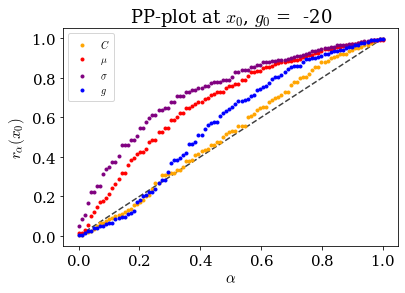

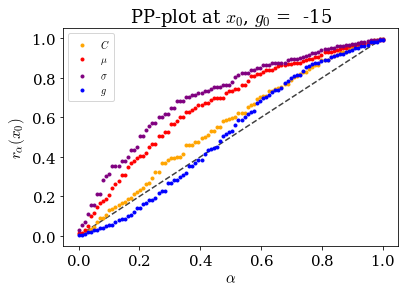

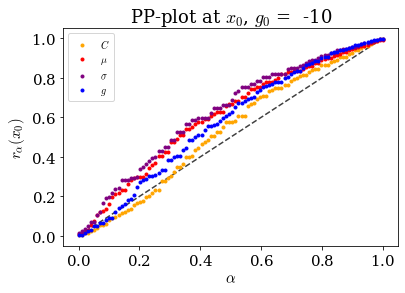

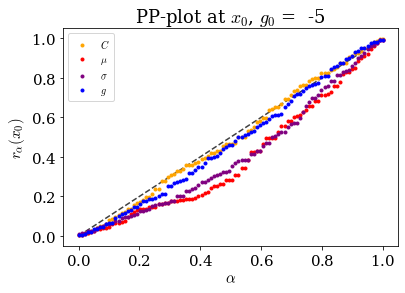

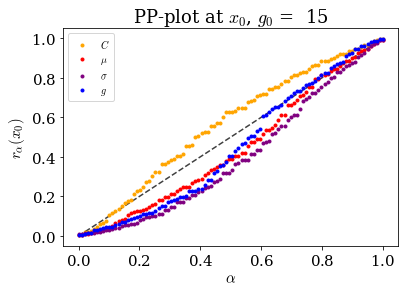

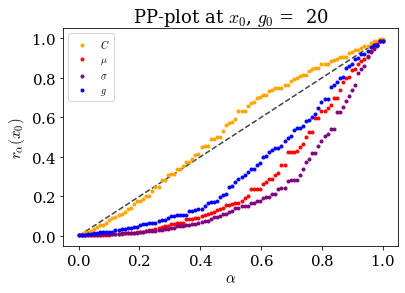

In [264]:
# pp-plots for rejected x_0
from diagnostics.pp_plots import multi_pp_plots
x_eval_names = [r', $g_0$ = '+f' {g}' for g in [-20,-15,-10,-5,15,20]]
param_names = [r'$C$ ', r'$\mu$ ', r'$\sigma$ ', r'$g$ ']
multi_pp_plots([lct_hg90_t1000_na100_path_list[:4]+lct_hg90_t1000_na100_path_list[7:]] , x_eval_names, param_names,pvalues=False)

#### Option two: PCA Image

##### Generate test observations $x_0$ 


In [27]:
# # ground-truth parameters to generate observation
# theta_obs, x_obs = simulate_for_sbi(
#         simulator=simulator, proposal=prior, num_simulations=20
# )
# x_obs = summary_extractor(x_obs)
# torch.save([theta_obs,x_obs], PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')
x_obs = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/pca_experiment_new.pkl')[1]

# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(x_obs[:,:,0]) 
# x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

##### Compute and combine p-values

0


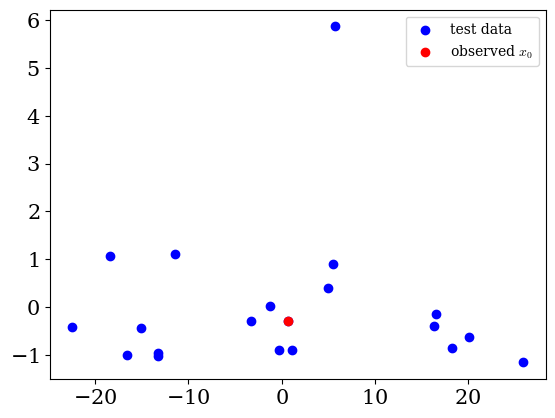

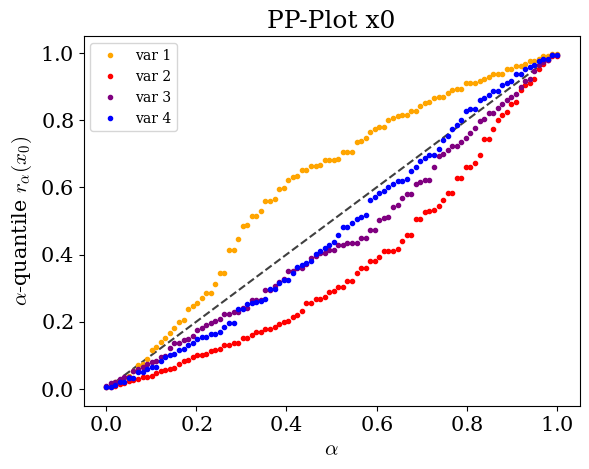

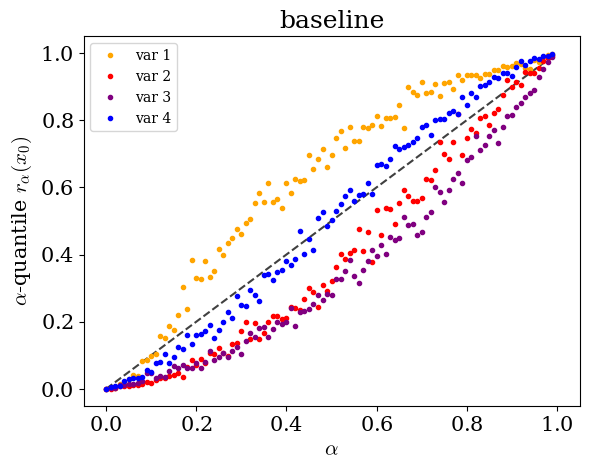

1


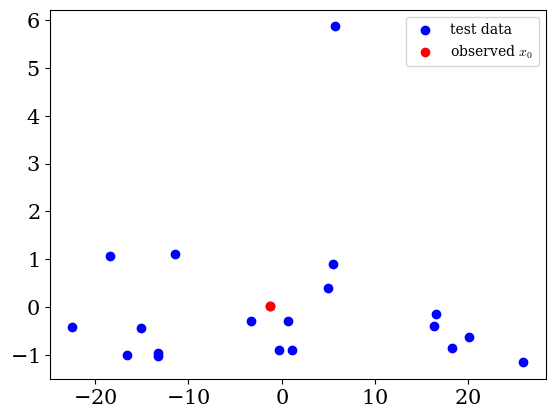

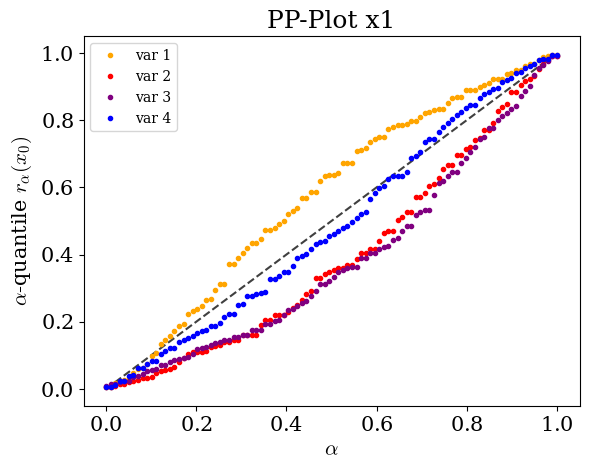

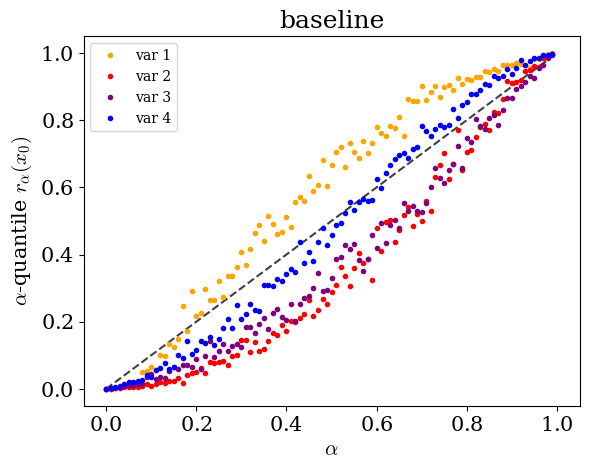

2


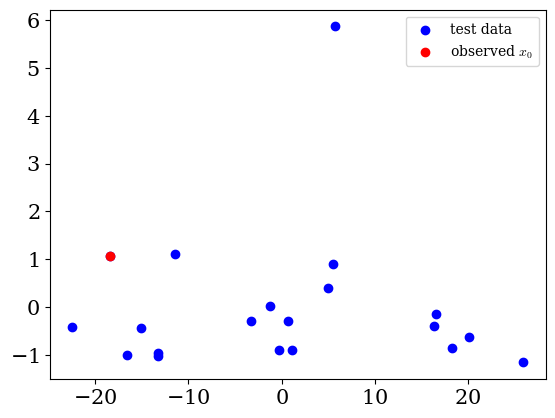

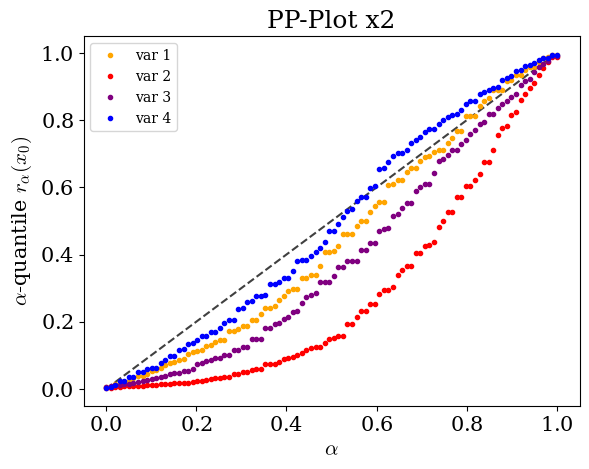

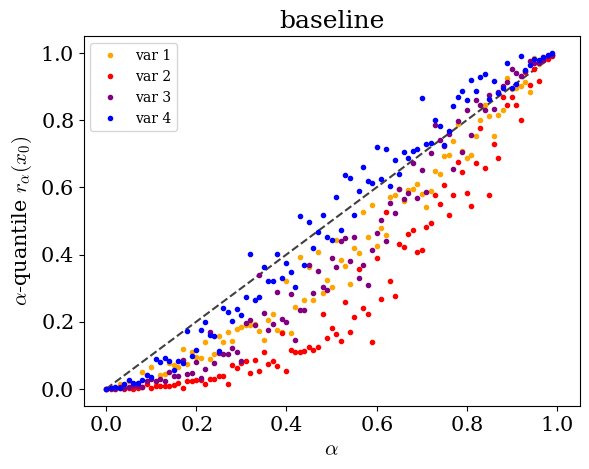

3


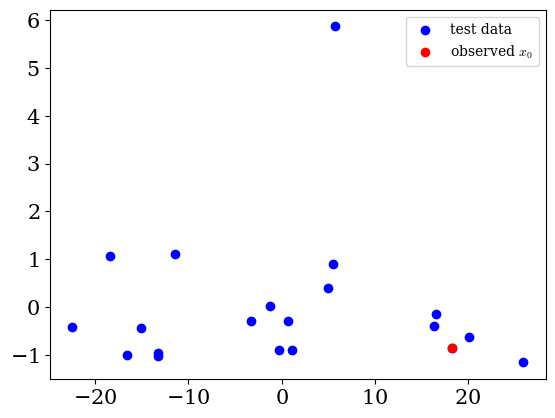

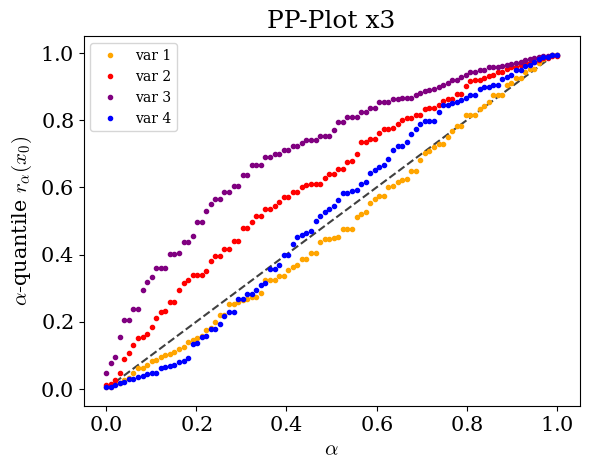

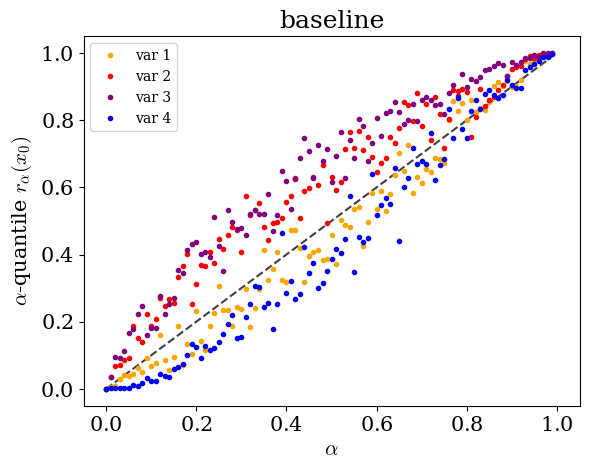

4


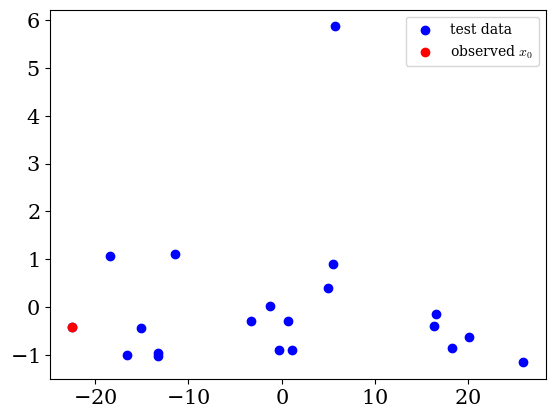

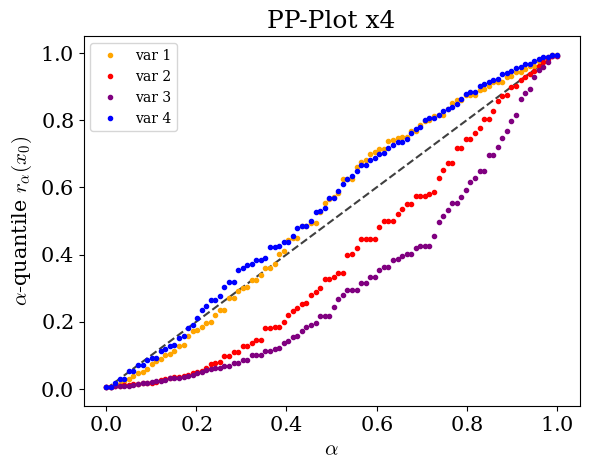

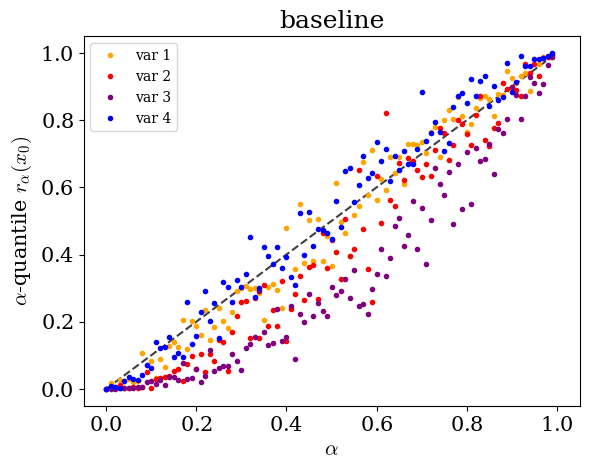

5


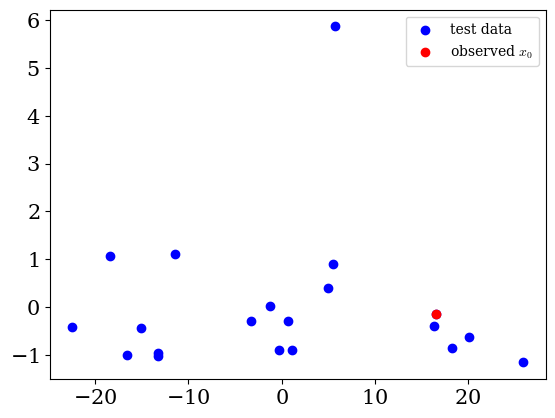

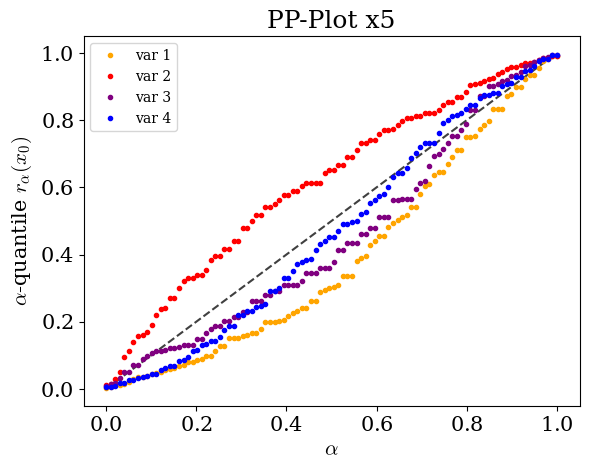

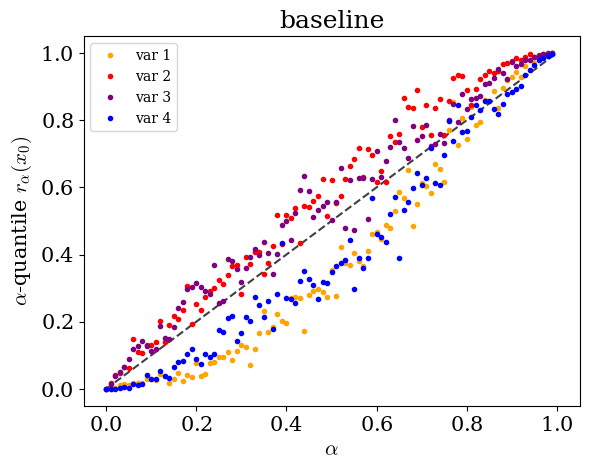

6


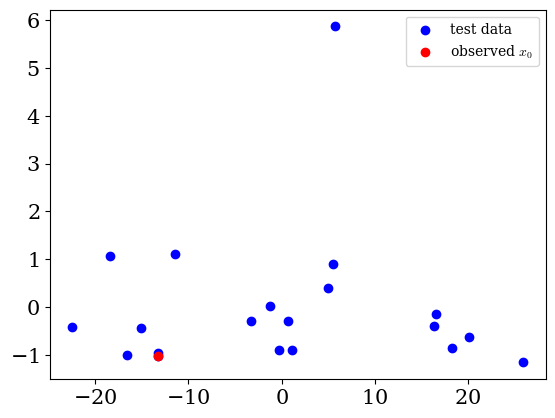

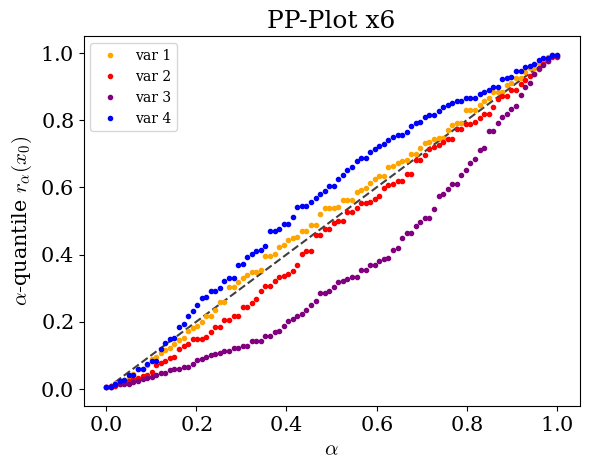

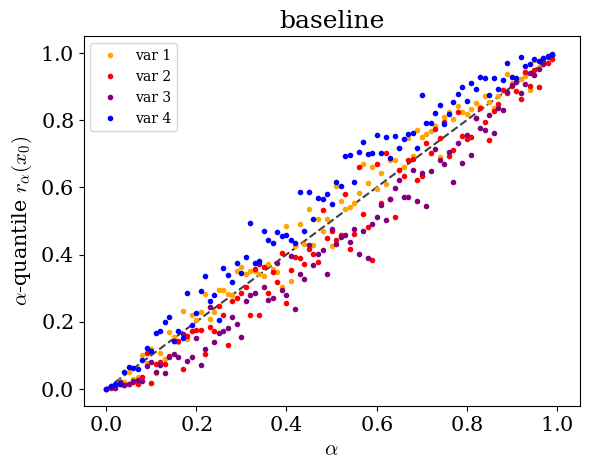

7


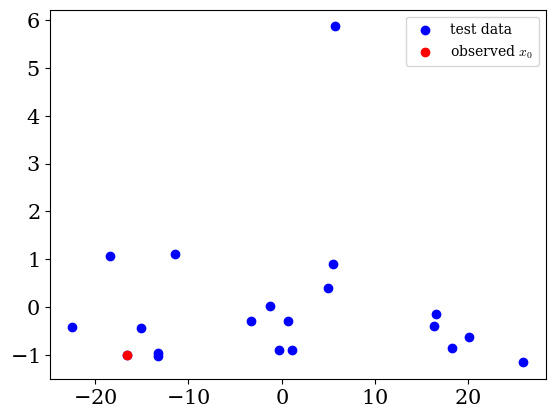

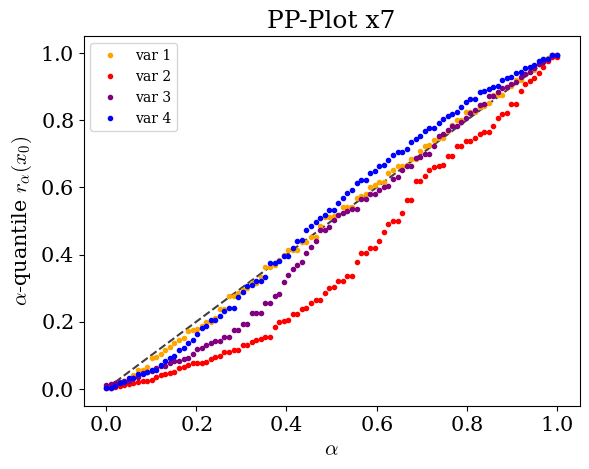

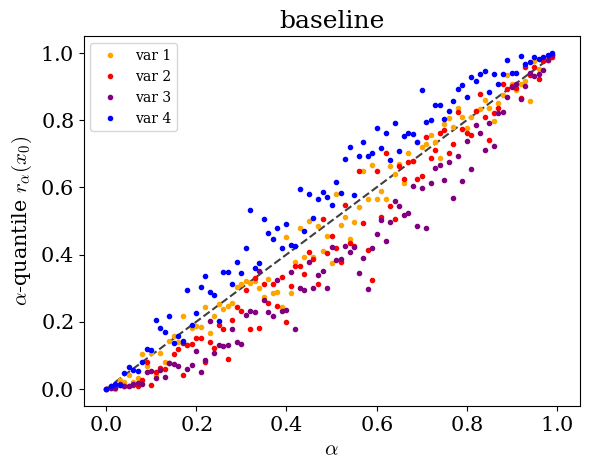

8


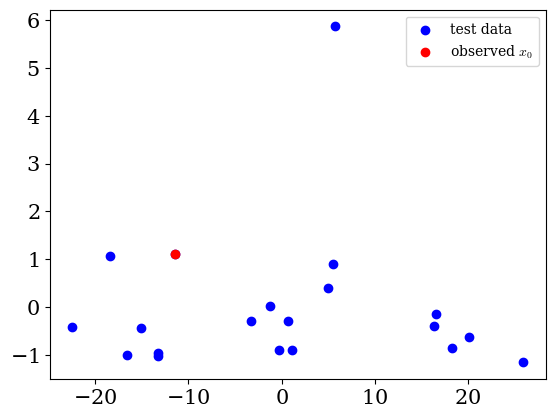

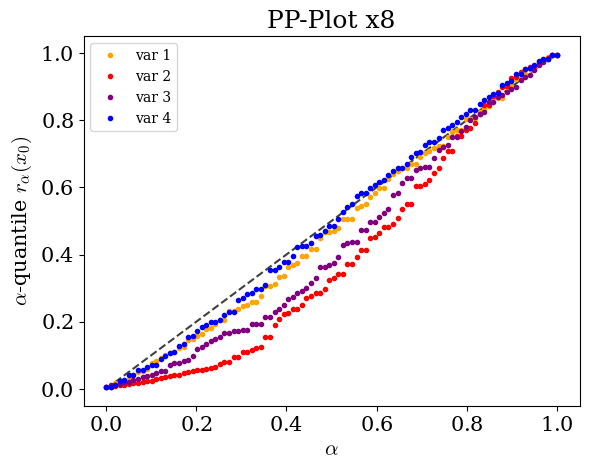

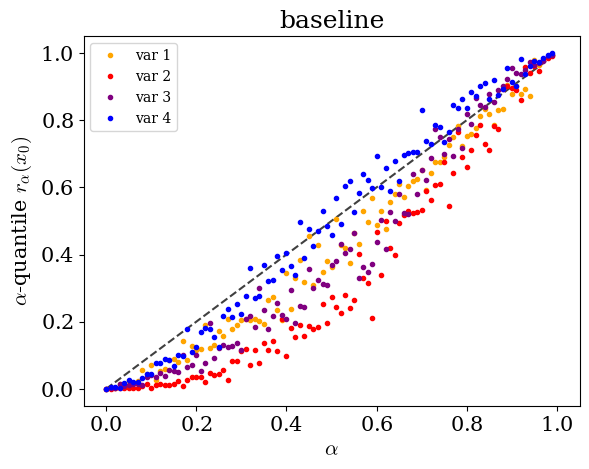

9


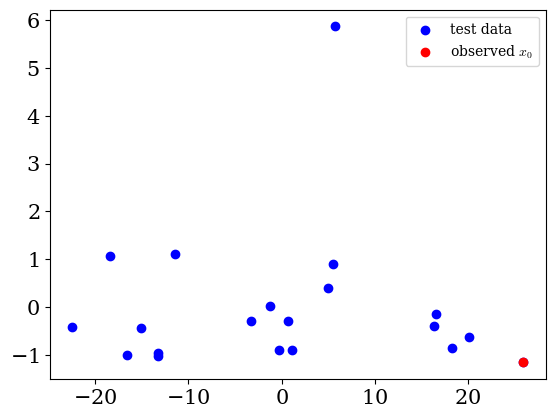

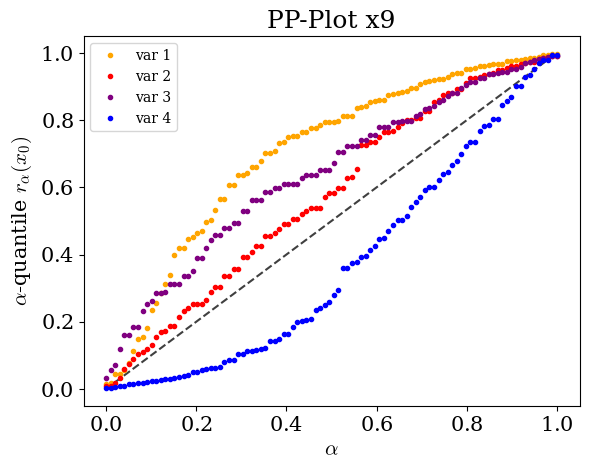

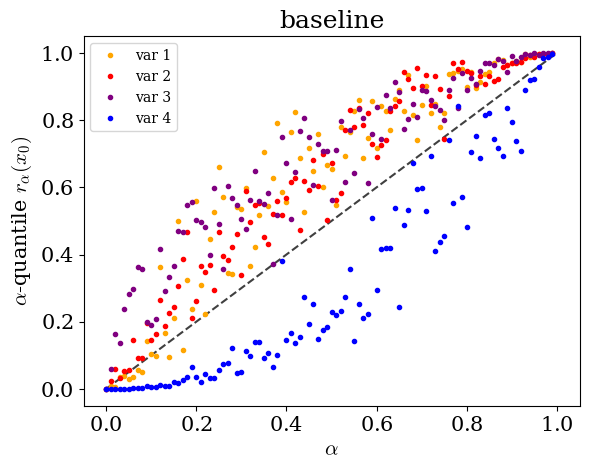

10


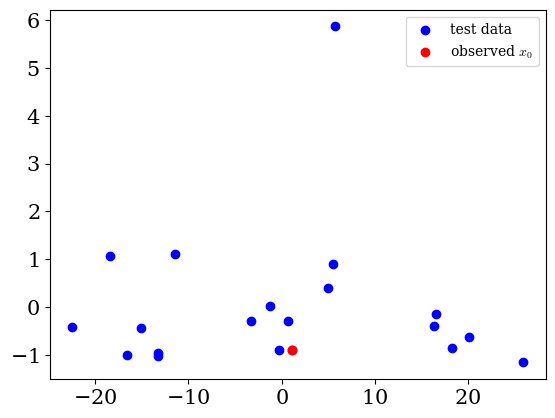

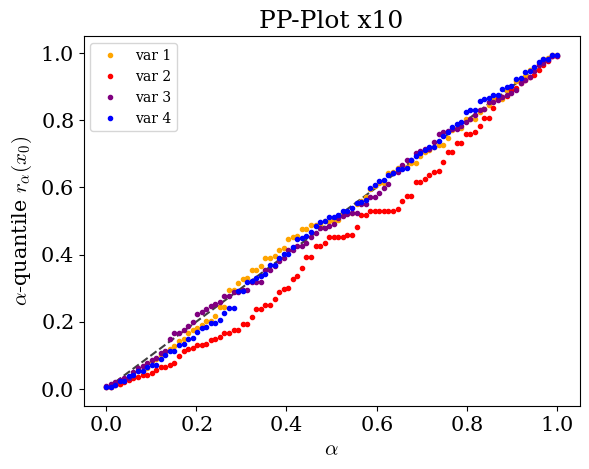

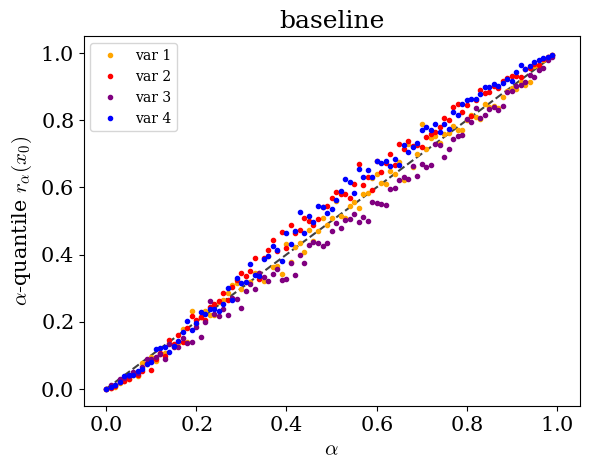

11


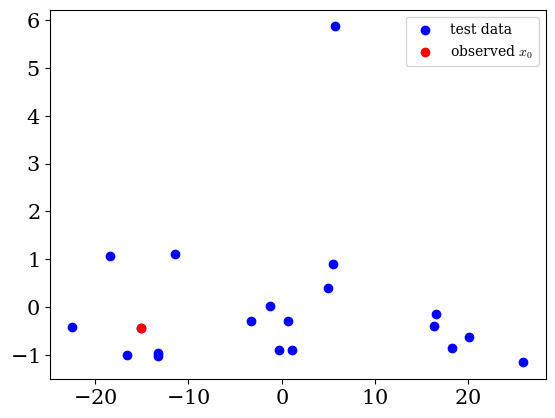

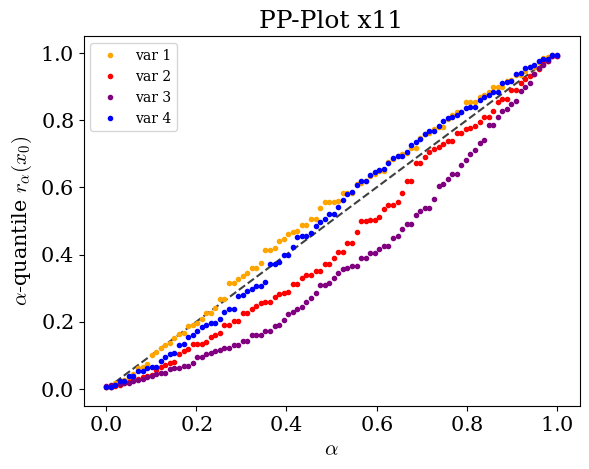

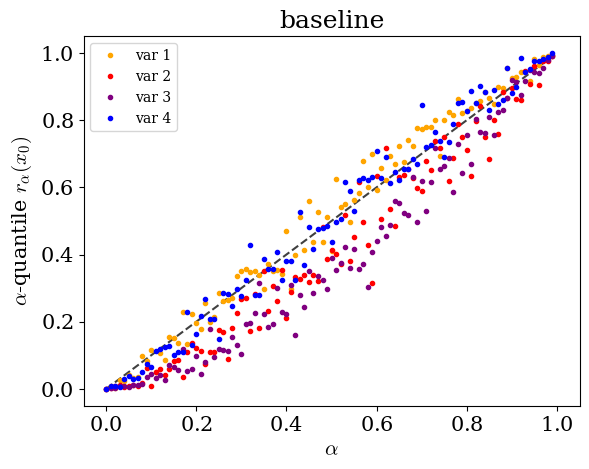

12


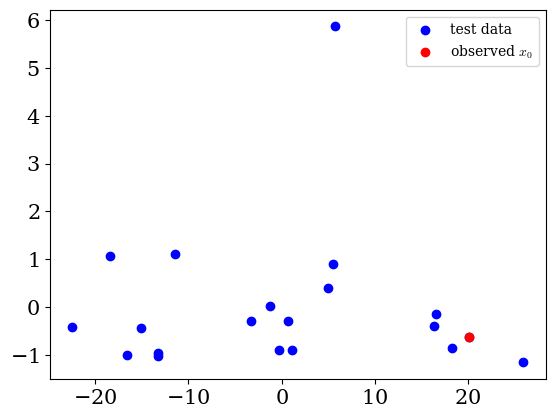

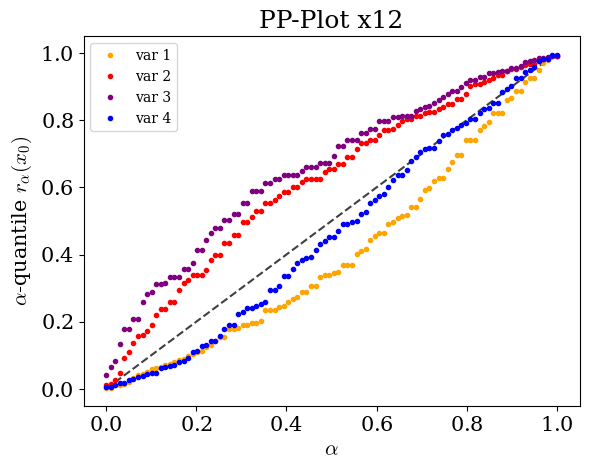

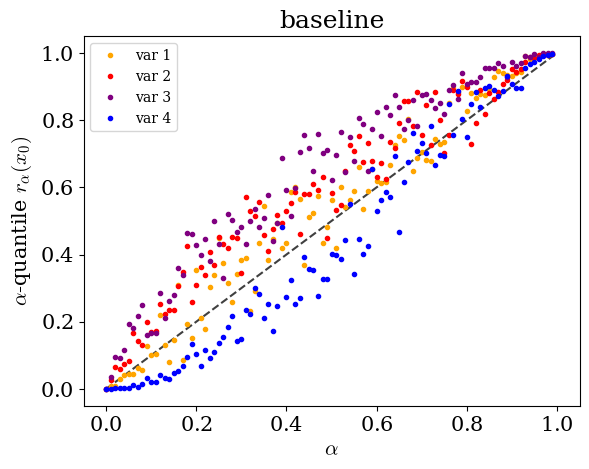

13


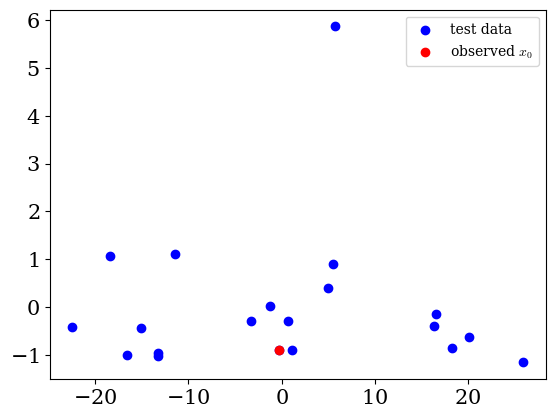

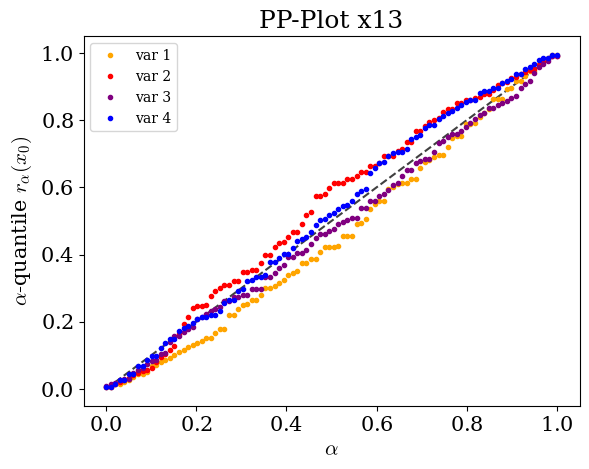

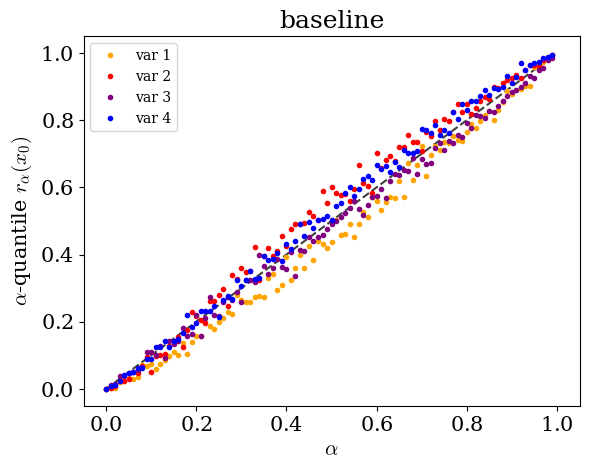

14


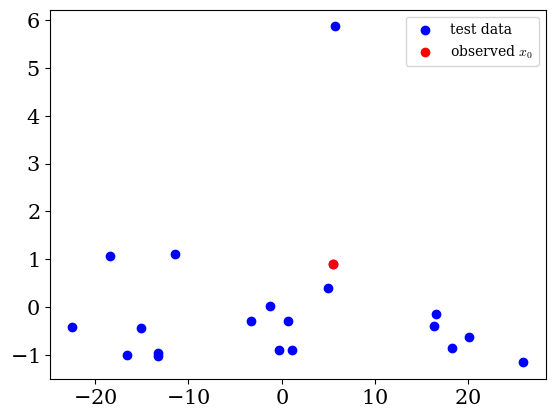

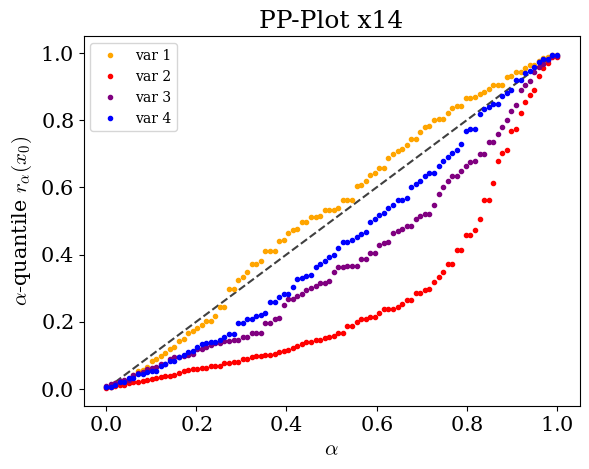

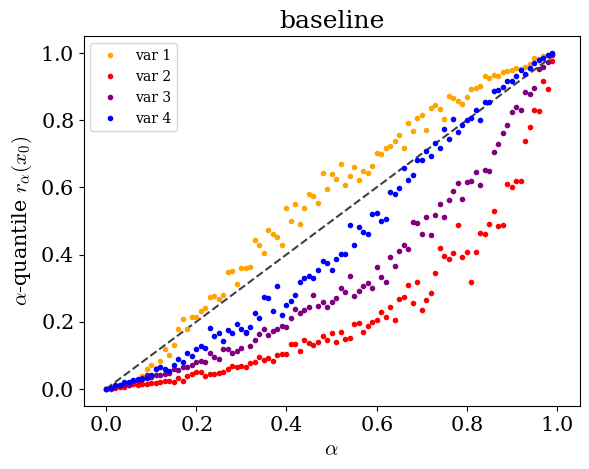

15


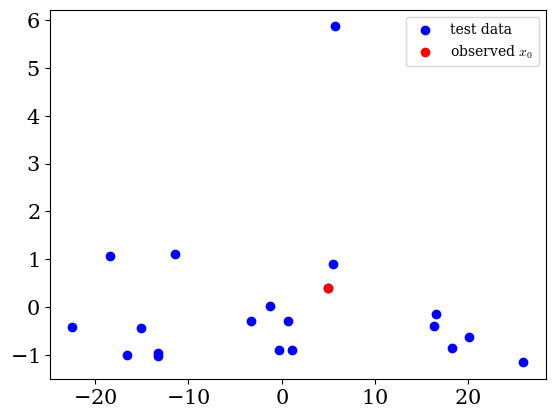

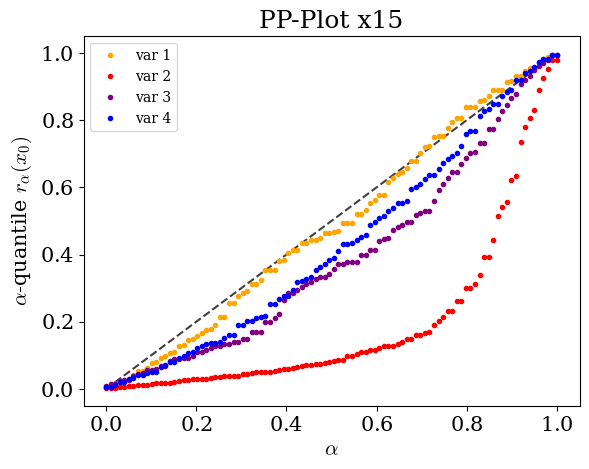

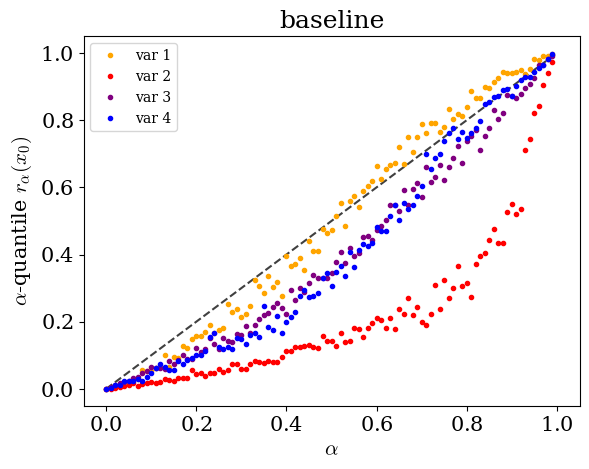

16


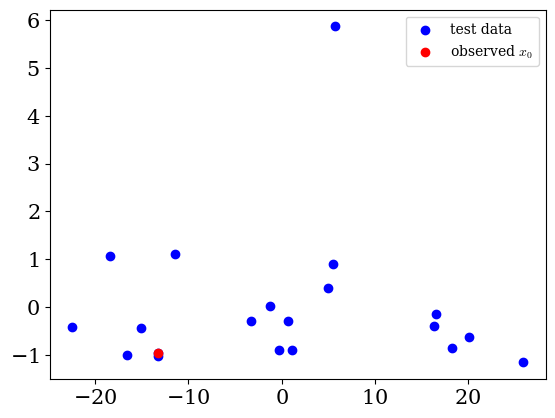

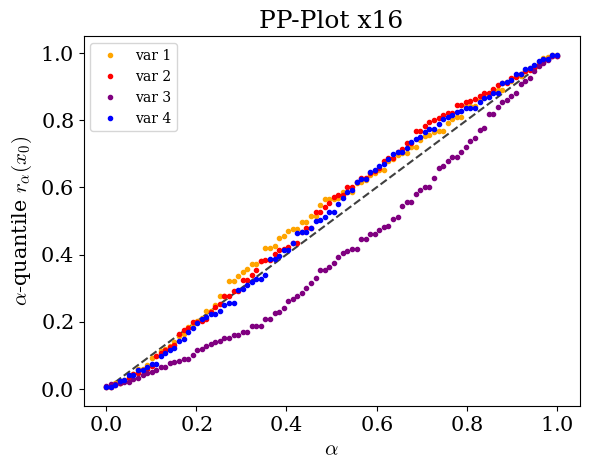

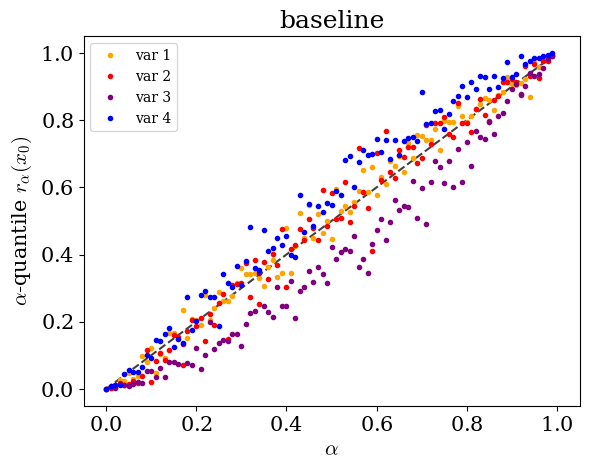

17


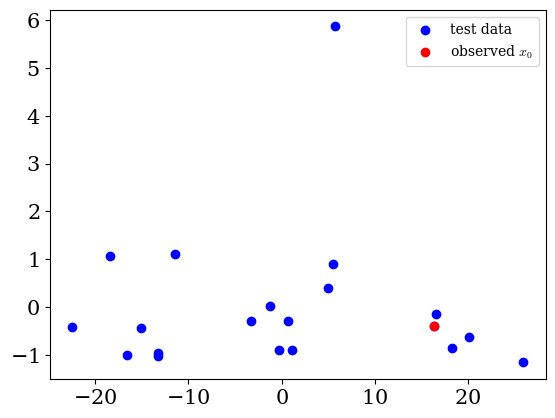

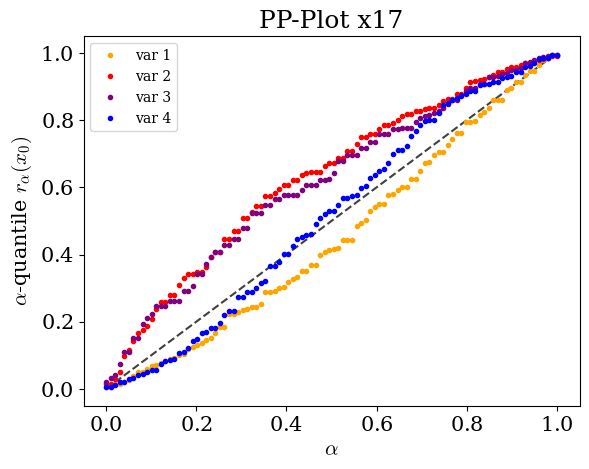

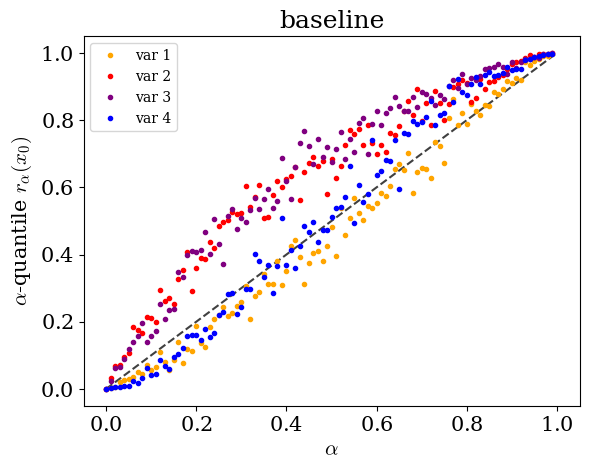

18


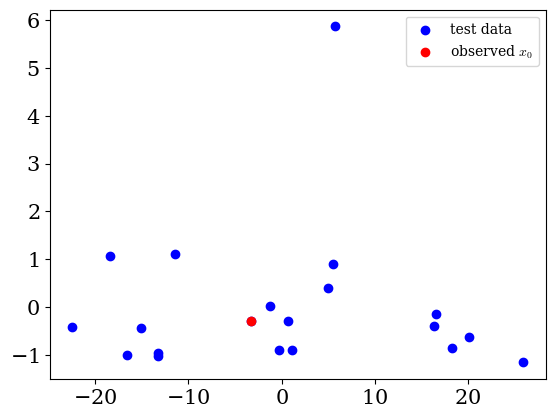

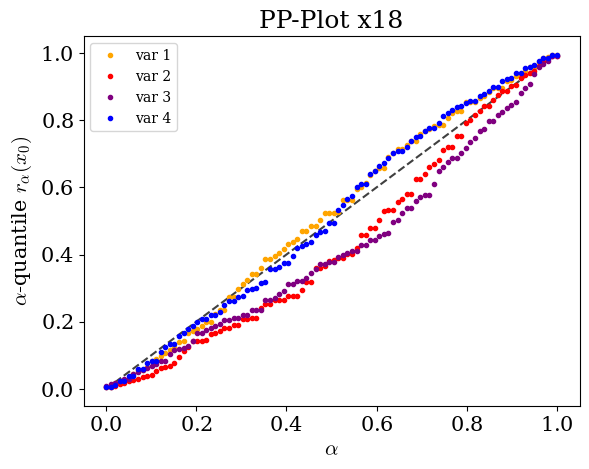

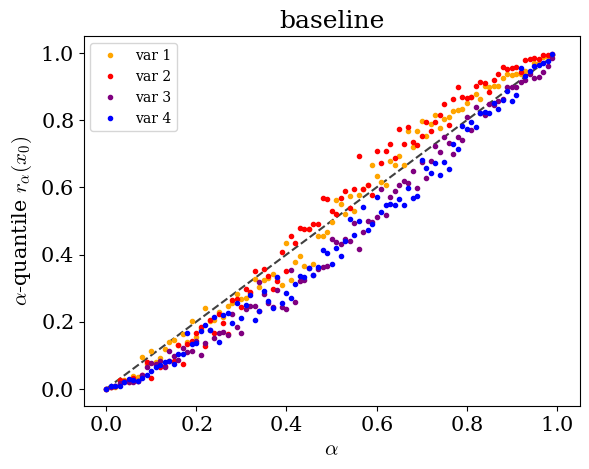

19


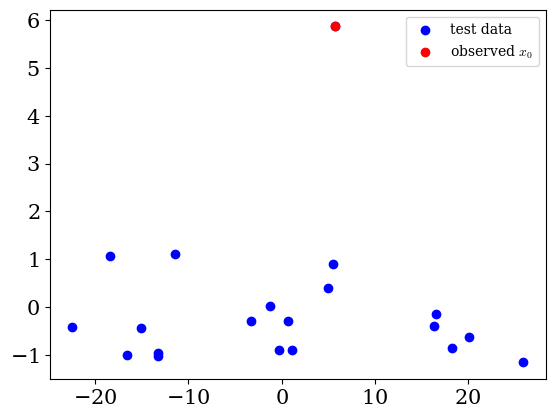

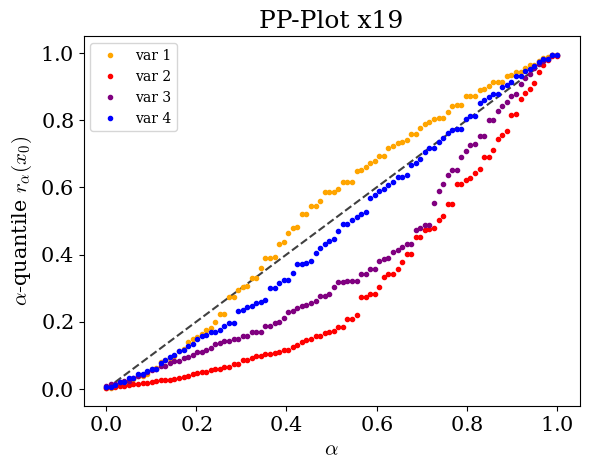

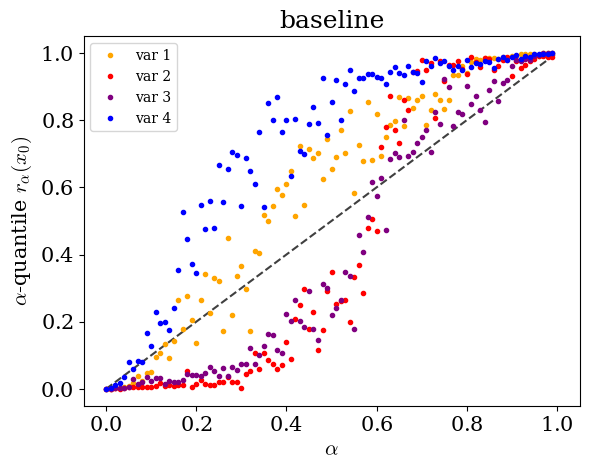

In [28]:
from scipy.stats import combine_pvalues
from sklearn.decomposition import PCA


ntrials = 1000
# path_lct = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_ntrails_{ntrials}_n_alphas_{21}"
# path_lct_hg = PATH_EXPERIMENT + f"pvalues/naive_nextra_{N_EXTRA}_nsim_{50000}/lct_results_histgrad90_ntrails_{ntrials}_n_alphas_{21}"
# path_r_alpha = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_{METHOD}_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}"
# path_r_alpha_hg = PATH_EXPERIMENT + f"r_alpha_learned/r_alpha_learned_histgrad90_{METHOD}_nextra_{N_EXTRA}_nsim_{B}"

# path_lct_hg_new = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_sample50_histgrad90_ntrials_{ntrials}_n_alphas_{100}"
# path_lct_baseline = PATH_EXPERIMENT+f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/lct_results_baseline_mlp_nalpha_100_ntrials_{ntrials}_n_alphas_{100}"

k_list = [19,18,15,14,13,10,9,17]
pca = PCA(n_components=2)
pca.fit(x_obs[:,:,0]) 
x_new = pca.transform(x_obs[:,:,0])
# plt.scatter(x_new[:,0],x_new[:,1], color='blue')

combined_pvalues = []
combined_pvalues_hg = []
for dim in range(1,5):
    for k in range(20):
        # pvalues = torch.load(path_lct+f"_pca_x{k}_new.pkl")['pvalues']
        # lct_hg = torch.load(path_lct_hg+f"_pca_x{k}_new.pkl")
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']

        lct_hg = torch.load(path_lct_hg+f"_pca_x{k}.pkl")
        lct_baseline = torch.load(path_lct_baseline+f"_pca_x{k}.pkl")
        
        # pvalues_hg, r_alpha, r_alpha_null_list = lct_hg['pvalues'], lct_hg['r_alpha_learned'], lct_hg['r_alpha_null_list']
        r_alpha = lct_hg['r_alpha_learned']
        r_alpha_baseline = lct_baseline['r_alpha_learned']
        if dim ==1:

            # COMBINED p-VALUES
            # combined_pvalues.append(combine_pvalues(list(pvalues.values()))[1])
            # combined_pvalues_hg.append(combine_pvalues(list(pvalues_hg.values()))[1])
            print(k)
            # print(f'pvalues = {pvalues_hg}')
            # print(combined_pvalues[-1])
            # print(combined_pvalues_hg[-1])

            # PCA PLOT 
            x_new_k = x_new[k]
            fig, ax = plt.subplots()
            ax.scatter(x_new[:,0],x_new[:,1], color='blue', label='test data')
            ax.scatter(x_new_k[0],x_new_k[1], color='red', label=r'observed $x_0$')
            # ax.annotate(f'pvalue = {combined_pvalues_hg[-1]}', (x_new_k[0], x_new_k[1]))
            plt.legend()
            # plt.title(f'pvalue = {combined_pvalues_hg[-1]}')
            plt.show()

            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 1, 100),
                r_alpha_learned=[
                    r_alpha["dim_1"],
                    r_alpha["dim_2"],
                    r_alpha["dim_3"],
                    r_alpha["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"PP-Plot x{k}",
            )

            # # for null hypothesis
            # PP_plot_1D(
            #     PIT_values=None,
            #     alphas=np.linspace(0, 1, 21),
            #     r_alpha_learned=[
            #         r_alpha_null_list[50]["dim_1"],
            #         r_alpha_null_list[50]["dim_2"],
            #         r_alpha_null_list[50]["dim_3"],
            #         r_alpha_null_list[50]["dim_4"],
            #     ],
            #     colors=["orange", "red"],
            #     colors_r_alpha=["orange", "red", "purple", "blue"],
            #     labels=["var 1", "var 2", "var 3", "var 4"],
            #     title=f"pvalues = {pvalues_hg}",
            # )

            # PP-PLOT BASELINE
            # on grid
            # r_alpha_learned = torch.load(path_r_alpha+f"_pca_x{k}_new.pkl")
            PP_plot_1D(
                PIT_values=None,
                alphas=np.linspace(0, 0.99, 100),
                r_alpha_learned=[
                    r_alpha_baseline["dim_1"],
                    r_alpha_baseline["dim_2"],
                    r_alpha_baseline["dim_3"],
                    r_alpha_baseline["dim_4"],
                ],
                colors=["orange", "red"],
                colors_r_alpha=["orange", "red", "purple", "blue"],
                labels=["var 1", "var 2", "var 3", "var 4"],
                title=f"baseline",
            )

